In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from utils import convert_to_cat, one_hot_encode
from utils import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from utils import get_classification_summary, get_table_metrics, get_epsilon_plots
from utils import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in the original data
compas_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_data = pd.read_csv(compas_url)
compas_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# Get the categorical data
cat_compas = convert_to_cat(compas_data, dataset="compas")
cat_compas

,age,priors_count,sex,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,length_of_stay,race,two_year_recid
1,0,0,1,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,0
6,2,2,1,0,0,0,0,0,1,0
8,2,0,0,0,0,0,1,0,1,1
10,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,1,0,0,0,1,0,0,0
7208,1,0,1,0,0,0,0,0,0,1
7209,1,0,1,0,0,0,0,0,0,1
7210,1,0,1,0,0,0,0,0,0,1


In [5]:
# Get the one-hot encoded data
encoded_compas = one_hot_encode(cat_compas, dataset="compas")
encoded_compas

,sex,c_charge_degree,race,two_year_recid,age_1,age_2,age_3,age_4,priors_count_1,priors_count_2,...,juv_other_count_2,juv_other_count_3,juv_other_count_4,juv_other_count_5,juv_other_count_6,juv_other_count_7,length_of_stay_1,length_of_stay_2,length_of_stay_3,length_of_stay_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7208,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7209,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7210,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_compas, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_compas, test_size=0.2, random_state=0)

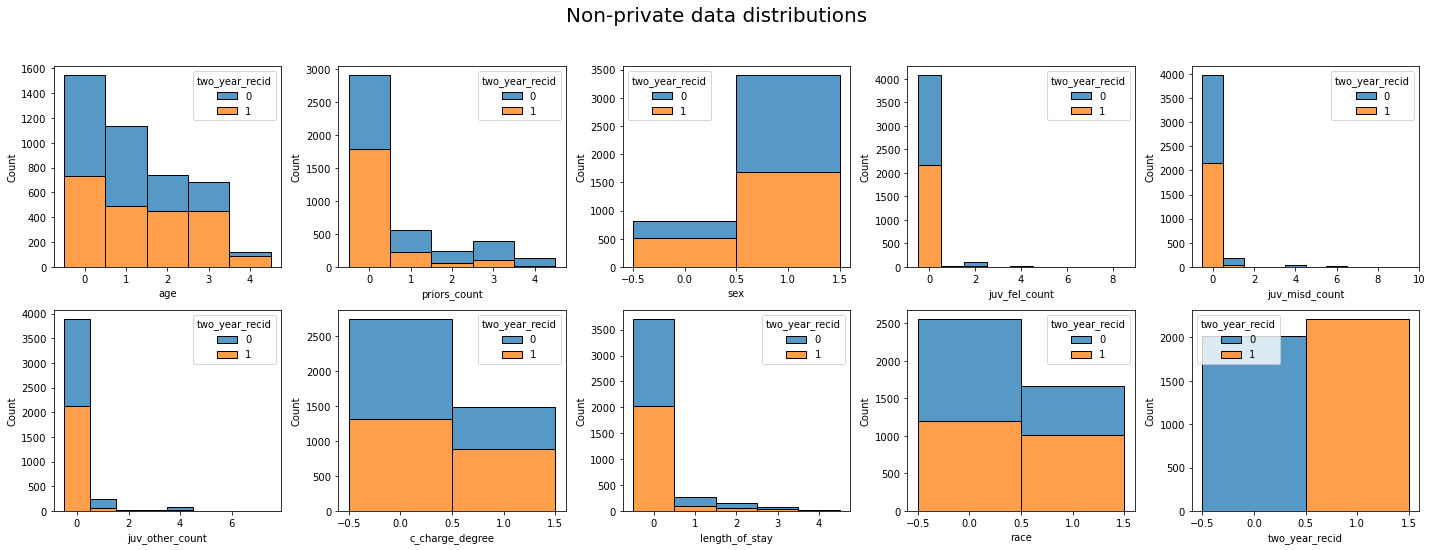

In [7]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", dataset="compas")

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Black: 0.6082, White: 0.7612

False positive rates:
Black: 0.3102, White: 0.6325

Equalized odds distances:
y=1: 0.1530, y=0: 0.3223

Classification accuracies:
Black: 0.6479, White: 0.6106

F1-score: 0.6723

Avg train pred: 0.5647, Avg test pred: 0.5653


In [9]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Black: 0.5893, White: 0.8097

False positive rates:
Black: 0.3531, White: 0.7410

Equalized odds distances:
y=1: 0.2204, y=0: 0.3878

Classification accuracies:
Black: 0.6174, White: 0.5991

F1-score: 0.6628

Avg train pred: 0.5905, Avg test pred: 0.6013


# 3. New MWEM synthesis

In [10]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [11]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10, dataset="compas", results_dir="compas/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

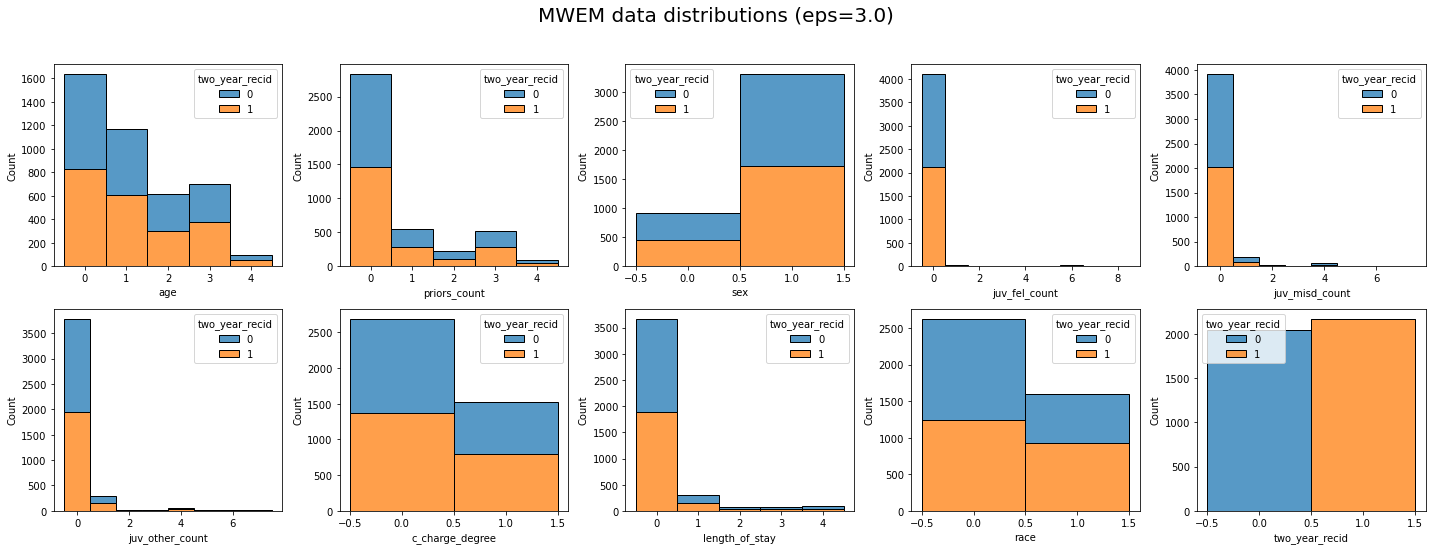

In [13]:
MWEM_eps3_rep0 = pd.read_csv("compas/MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset="compas")

In [17]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.877
FPR difference median: 0.802
F1-score median: 0.542


In [15]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.534
FPR difference median: 0.526
F1-score median: 0.559


# 4. New DP-CTGAN synthesis

In [19]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=10, dataset="compas", results_dir="compas/")

Epoch 1, Loss G: 0.6625, Loss D: 1.3821
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6597, Loss D: 1.3831
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6531, Loss D: 1.3777
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6485, Loss D: 1.3752
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6430, Loss D: 1.3788
epsilon is 0.8444493438584324, alpha is 22.0
Completed eps=1.0, rep=1.
Epoch 1, Loss G: 0.6629, Loss D: 1.3791
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6565, Loss D: 1.3767
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6516, Loss D: 1.3792
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6491, Loss D: 1.3809
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6430, Loss D: 1.3802
epsilon is 0.8444493438584324, alpha is 22.0
Completed eps=1.0, rep=2.
Epoch 1, Loss G: 0.6643, Loss D: 1.3814
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2,

epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6353, Loss D: 1.3773
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6340, Loss D: 1.3844
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6247, Loss D: 1.3908
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6257, Loss D: 1.3945
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6245, Loss D: 1.3971
epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6227, Loss D: 1.3962
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6256, Loss D: 1.3903
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6279, Loss D: 1.3910
epsilon is 1.744376182327897, alpha is 12.0
Completed eps=2.0, rep=3.
Epoch 1, Loss G: 0.6606, Loss D: 1.3793
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6575, Loss D: 1.3790
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6539, Loss D: 1.3795
epsilon is 0.5937816873875195, 

Epoch 2, Loss G: 0.6576, Loss D: 1.3808
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6525, Loss D: 1.3798
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6468, Loss D: 1.3793
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6441, Loss D: 1.3797
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6410, Loss D: 1.3822
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6368, Loss D: 1.3812
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6363, Loss D: 1.3785
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6336, Loss D: 1.3803
epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6325, Loss D: 1.3853
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6274, Loss D: 1.3895
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6224, Loss D: 1.3925
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6224, Loss D: 1.3937
epsilon is 1.4976889910

epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6300, Loss D: 1.3964
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6313, Loss D: 1.3934
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6343, Loss D: 1.3907
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G: 0.6355, Loss D: 1.3945
epsilon is 2.400667632221031, alpha is 9.5
Epoch 31, Loss G: 0.6339, Loss D: 1.3943
epsilon is 2.4451804020978996, alpha is 9.3
Epoch 32, Loss G: 0.6320, Loss D: 1.3977
epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6282, Loss D: 1.3985
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6297, Loss D: 1.3988
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6316, Loss D: 1.3986
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6302, Loss D: 1.3980
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6315, Loss D: 1.3967
epsilon is 2.6997930190185975, alpha is 8.7
Completed eps=3.0, rep

Epoch 11, Loss G: 0.6325, Loss D: 1.3830
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6285, Loss D: 1.3900
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6256, Loss D: 1.3933
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6233, Loss D: 1.3933
epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6239, Loss D: 1.3942
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6243, Loss D: 1.3967
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6239, Loss D: 1.3943
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6255, Loss D: 1.3912
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6268, Loss D: 1.3878
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6271, Loss D: 1.3916
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6274, Loss D: 1.3906
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6272, Loss D: 1.3939
epsilon is 2.01

epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6292, Loss D: 1.4000
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6274, Loss D: 1.4042
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6302, Loss D: 1.3983
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6314, Loss D: 1.3941
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6334, Loss D: 1.3882
epsilon is 2.6997930190185975, alpha is 8.7
Completed eps=3.0, rep=7.
Epoch 1, Loss G: 0.6618, Loss D: 1.3811
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6572, Loss D: 1.3783
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6543, Loss D: 1.3792
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6493, Loss D: 1.3768
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6463, Loss D: 1.3792
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6402, Loss D: 1.3799
epsilon is 0.947271907224541, alpha is

Epoch 17, Loss G: 0.6280, Loss D: 1.3941
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6278, Loss D: 1.3870
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6293, Loss D: 1.3911
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6272, Loss D: 1.3922
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6257, Loss D: 1.3940
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6252, Loss D: 1.3983
epsilon is 2.0172921237605914, alpha is 10.8
Epoch 23, Loss G: 0.6266, Loss D: 1.4001
epsilon is 2.068321671111616, alpha is 10.6
Epoch 24, Loss G: 0.6237, Loss D: 1.3980
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6282, Loss D: 1.3985
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Loss G: 0.6322, Loss D: 1.3944
epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6331, Loss D: 1.3936
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6376, Loss D: 1.3909
epsilon is 2.30966

Epoch 15, Loss G: 0.6236, Loss D: 1.3902
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6249, Loss D: 1.3938
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6244, Loss D: 1.3930
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6266, Loss D: 1.3929
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6288, Loss D: 1.3968
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6267, Loss D: 1.3935
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6264, Loss D: 1.3924
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6283, Loss D: 1.3888
epsilon is 2.0172921237605914, alpha is 10.8
Epoch 23, Loss G: 0.6264, Loss D: 1.3977
epsilon is 2.068321671111616, alpha is 10.6
Epoch 24, Loss G: 0.6277, Loss D: 1.4027
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6253, Loss D: 1.3999
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Loss G: 0.6253, Loss D: 1.3997
epsilon is 2.2156

Epoch 50, Loss G: 0.6382, Loss D: 1.3942
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6409, Loss D: 1.3943
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6447, Loss D: 1.3936
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6471, Loss D: 1.3968
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6507, Loss D: 1.3867
epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6565, Loss D: 1.3872
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6596, Loss D: 1.3864
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6545, Loss D: 1.3860
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6532, Loss D: 1.3928
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6522, Loss D: 1.3904
epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6524, Loss D: 1.3900
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6531, Loss D: 1.3881
epsilon is 3.5736524564531247, 

Epoch 24, Loss G: 0.6255, Loss D: 1.3938
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6266, Loss D: 1.3964
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Loss G: 0.6232, Loss D: 1.4015
epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6272, Loss D: 1.3986
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6301, Loss D: 1.4043
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6307, Loss D: 1.3958
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G: 0.6331, Loss D: 1.3960
epsilon is 2.400667632221031, alpha is 9.5
Epoch 31, Loss G: 0.6344, Loss D: 1.3927
epsilon is 2.4451804020978996, alpha is 9.3
Epoch 32, Loss G: 0.6325, Loss D: 1.3924
epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6357, Loss D: 1.3887
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6373, Loss D: 1.3871
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6379, Loss D: 1.3899
epsilon is 2.617084257201

epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6505, Loss D: 1.3897
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6476, Loss D: 1.3907
epsilon is 3.5736524564531247, alpha is 7.0
Completed eps=4.0, rep=6.
Epoch 1, Loss G: 0.6632, Loss D: 1.3786
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6597, Loss D: 1.3804
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6555, Loss D: 1.3820
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6494, Loss D: 1.3754
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6416, Loss D: 1.3802
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6416, Loss D: 1.3776
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6382, Loss D: 1.3796
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6369, Loss D: 1.3794
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6367, Loss D: 1.3764
epsilon is 1.2096288035026117, alpha is 1

epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6352, Loss D: 1.3926
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6343, Loss D: 1.3938
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6359, Loss D: 1.3928
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6328, Loss D: 1.3945
epsilon is 2.6997930190185975, alpha is 8.7
Epoch 38, Loss G: 0.6321, Loss D: 1.3840
epsilon is 2.7404017569942174, alpha is 8.6
Epoch 39, Loss G: 0.6328, Loss D: 1.3870
epsilon is 2.7805407155975455, alpha is 8.5
Epoch 40, Loss G: 0.6394, Loss D: 1.3846
epsilon is 2.8202316972855708, alpha is 8.4
Epoch 41, Loss G: 0.6343, Loss D: 1.3861
epsilon is 2.8594976448768015, alpha is 8.3
Epoch 42, Loss G: 0.6342, Loss D: 1.3865
epsilon is 2.8983627220394212, alpha is 8.2
Epoch 43, Loss G: 0.6286, Loss D: 1.3934
epsilon is 2.9368524006520214, alpha is 8.1
Epoch 44, Loss G: 0.6251, Loss D: 1.4028
epsilon is 2.9749375167984877, alpha is 8.1
Epoch 45, Loss G: 0.6

epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6373, Loss D: 1.3793
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6365, Loss D: 1.3792
epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6354, Loss D: 1.3799
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6297, Loss D: 1.3840
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6233, Loss D: 1.3888
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6240, Loss D: 1.3942
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6228, Loss D: 1.3918
epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6248, Loss D: 1.3955
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6258, Loss D: 1.3930
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6266, Loss D: 1.3912
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6250, Loss D: 1.3936
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss

epsilon is 2.8983627220394212, alpha is 8.2
Epoch 43, Loss G: 0.6272, Loss D: 1.3943
epsilon is 2.9368524006520214, alpha is 8.1
Epoch 44, Loss G: 0.6247, Loss D: 1.3960
epsilon is 2.9749375167984877, alpha is 8.1
Epoch 45, Loss G: 0.6284, Loss D: 1.3989
epsilon is 3.0125916282748055, alpha is 8.0
Epoch 46, Loss G: 0.6258, Loss D: 1.4027
epsilon is 3.0499260385038407, alpha is 7.9
Epoch 47, Loss G: 0.6331, Loss D: 1.3979
epsilon is 3.0869707469895626, alpha is 7.8
Epoch 48, Loss G: 0.6348, Loss D: 1.3945
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6379, Loss D: 1.3958
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6410, Loss D: 1.3942
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6402, Loss D: 1.3922
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6396, Loss D: 1.3926
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6433, Loss D: 1.3899
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.645

Epoch 48, Loss G: 0.6332, Loss D: 1.3956
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6316, Loss D: 1.3920
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6354, Loss D: 1.3986
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6352, Loss D: 1.3949
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6386, Loss D: 1.3936
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6403, Loss D: 1.3915
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6396, Loss D: 1.3886
epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6467, Loss D: 1.3881
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6495, Loss D: 1.3911
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6504, Loss D: 1.3885
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6503, Loss D: 1.3897
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6528, Loss D: 1.3895
epsilon is 3.507266409340386, 

epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6460, Loss D: 1.3920
epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6428, Loss D: 1.3939
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6487, Loss D: 1.3916
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6488, Loss D: 1.3921
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6541, Loss D: 1.3859
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6555, Loss D: 1.3854
epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6586, Loss D: 1.3807
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6625, Loss D: 1.3819
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6603, Loss D: 1.3786
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6566, Loss D: 1.3861
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6566, Loss D: 1.3871
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6566, L

Epoch 59, Loss G: 0.6568, Loss D: 1.3818
epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6604, Loss D: 1.3871
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6553, Loss D: 1.3908
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6572, Loss D: 1.3929
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6544, Loss D: 1.3927
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6581, Loss D: 1.3872
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6583, Loss D: 1.3889
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6582, Loss D: 1.3846
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6590, Loss D: 1.3866
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6561, Loss D: 1.3838
epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6545, Loss D: 1.3895
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6521, Loss D: 1.3946
epsilon is 3.86165237087225

epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6492, Loss D: 1.3839
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6496, Loss D: 1.3863
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6506, Loss D: 1.3830
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6493, Loss D: 1.3858
epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6473, Loss D: 1.3885
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6464, Loss D: 1.3851
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6446, Loss D: 1.3936
epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6389, Loss D: 1.3961
epsilon is 3.923412505078864, alpha is 6.6
Epoch 73, Loss G: 0.6377, Loss D: 1.4001
epsilon is 3.9541952858204525, alpha is 6.5
Epoch 74, Loss G: 0.6381, Loss D: 1.3958
epsilon is 3.98454017817386, alpha is 6.5
Epoch 75, Loss G: 0.6411, Loss D: 1.4001
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6429, L

Epoch 70, Loss G: 0.6393, Loss D: 1.3890
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6400, Loss D: 1.3937
epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6377, Loss D: 1.3981
epsilon is 3.923412505078864, alpha is 6.6
Epoch 73, Loss G: 0.6368, Loss D: 1.3971
epsilon is 3.9541952858204525, alpha is 6.5
Epoch 74, Loss G: 0.6349, Loss D: 1.3984
epsilon is 3.98454017817386, alpha is 6.5
Epoch 75, Loss G: 0.6354, Loss D: 1.4000
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6348, Loss D: 1.3984
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6374, Loss D: 1.3958
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6387, Loss D: 1.3934
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6391, Loss D: 1.3911
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6403, Loss D: 1.3897
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6393, Loss D: 1.3949
epsilon is 4.1933559711726485,

epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6454, Loss D: 1.3900
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6450, Loss D: 1.3904
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6492, Loss D: 1.3872
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6513, Loss D: 1.3845
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6504, Loss D: 1.3852
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6497, Loss D: 1.3853
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6508, Loss D: 1.3919
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6486, Loss D: 1.3892
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6476, Loss D: 1.3861
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6459, Loss D: 1.3953
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6473, Loss D: 1.3867
epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6466, Los

Epoch 81, Loss G: 0.6401, Loss D: 1.3903
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6432, Loss D: 1.3946
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6460, Loss D: 1.3903
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6439, Loss D: 1.3870
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6443, Loss D: 1.3915
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6447, Loss D: 1.3888
epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6452, Loss D: 1.3898
epsilon is 4.366431937059239, alpha is 6.1
Epoch 88, Loss G: 0.6424, Loss D: 1.3893
epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6405, Loss D: 1.3906
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6431, Loss D: 1.3941
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6424, Loss D: 1.3945
epsilon is 4.479134515409658, alpha is 6.0
Completed eps=5.0, rep=8.
Epoch 1, Loss G: 0.6633, Loss D: 1.3836
epsilon i

epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6495, Loss D: 1.3891
epsilon is 4.366431937059239, alpha is 6.1
Epoch 88, Loss G: 0.6520, Loss D: 1.3856
epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6523, Loss D: 1.3831
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6560, Loss D: 1.3844
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6544, Loss D: 1.3829
epsilon is 4.479134515409658, alpha is 6.0
Completed eps=5.0, rep=9.
Epoch 1, Loss G: 0.6635, Loss D: 1.3753
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6568, Loss D: 1.3793
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6513, Loss D: 1.3787
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6499, Loss D: 1.3772
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6435, Loss D: 1.3810
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6420, Loss D: 1.3823
epsilon is 0.947271907224541, alpha is 20.0
E

Epoch 1, Loss G: 0.6576, Loss D: 1.3800
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6592, Loss D: 1.3766
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6526, Loss D: 1.3804
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6451, Loss D: 1.3765
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6429, Loss D: 1.3785
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6378, Loss D: 1.3815
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6374, Loss D: 1.3803
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6355, Loss D: 1.3821
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6357, Loss D: 1.3805
epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6306, Loss D: 1.3827
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6263, Loss D: 1.3838
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6239, Loss D: 1.3921
epsilon is 1.4300587249

Epoch 98, Loss G: 0.6371, Loss D: 1.3925
epsilon is 4.671657470884567, alpha is 5.8
Epoch 99, Loss G: 0.6372, Loss D: 1.3909
epsilon is 4.698650767777717, alpha is 5.8
Epoch 100, Loss G: 0.6364, Loss D: 1.3930
epsilon is 4.725644064670868, alpha is 5.8
Epoch 101, Loss G: 0.6375, Loss D: 1.3942
epsilon is 4.752637361564018, alpha is 5.8
Epoch 102, Loss G: 0.6417, Loss D: 1.3910
epsilon is 4.779196442001875, alpha is 5.7
Epoch 103, Loss G: 0.6399, Loss D: 1.3953
epsilon is 4.805712642424083, alpha is 5.7
Epoch 104, Loss G: 0.6398, Loss D: 1.3894
epsilon is 4.83222884284629, alpha is 5.7
Epoch 105, Loss G: 0.6396, Loss D: 1.3907
epsilon is 4.858745043268498, alpha is 5.7
Epoch 106, Loss G: 0.6427, Loss D: 1.3910
epsilon is 4.88512046873386, alpha is 5.6
Epoch 107, Loss G: 0.6434, Loss D: 1.3935
epsilon is 4.91115999619729, alpha is 5.6
Epoch 108, Loss G: 0.6424, Loss D: 1.3910
epsilon is 4.937199523660719, alpha is 5.6
Epoch 109, Loss G: 0.6404, Loss D: 1.3905
epsilon is 4.963239051124148

epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6553, Loss D: 1.3848
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6548, Loss D: 1.3848
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6543, Loss D: 1.3818
epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6578, Loss D: 1.3848
epsilon is 3.923412505078864, alpha is 6.6
Epoch 73, Loss G: 0.6556, Loss D: 1.3876
epsilon is 3.9541952858204525, alpha is 6.5
Epoch 74, Loss G: 0.6558, Loss D: 1.3870
epsilon is 3.98454017817386, alpha is 6.5
Epoch 75, Loss G: 0.6533, Loss D: 1.3918
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6503, Loss D: 1.3960
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6453, Loss D: 1.3987
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6422, Loss D: 1.4063
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6424, Loss D: 1.4010
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6428, L

Epoch 39, Loss G: 0.6381, Loss D: 1.3883
epsilon is 2.7805407155975455, alpha is 8.5
Epoch 40, Loss G: 0.6389, Loss D: 1.3855
epsilon is 2.8202316972855708, alpha is 8.4
Epoch 41, Loss G: 0.6349, Loss D: 1.3872
epsilon is 2.8594976448768015, alpha is 8.3
Epoch 42, Loss G: 0.6333, Loss D: 1.3900
epsilon is 2.8983627220394212, alpha is 8.2
Epoch 43, Loss G: 0.6327, Loss D: 1.3952
epsilon is 2.9368524006520214, alpha is 8.1
Epoch 44, Loss G: 0.6309, Loss D: 1.3965
epsilon is 2.9749375167984877, alpha is 8.1
Epoch 45, Loss G: 0.6309, Loss D: 1.3999
epsilon is 3.0125916282748055, alpha is 8.0
Epoch 46, Loss G: 0.6324, Loss D: 1.4005
epsilon is 3.0499260385038407, alpha is 7.9
Epoch 47, Loss G: 0.6343, Loss D: 1.3978
epsilon is 3.0869707469895626, alpha is 7.8
Epoch 48, Loss G: 0.6399, Loss D: 1.3959
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6419, Loss D: 1.3940
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6417, Loss D: 1.3875
epsilon is 3.19597419743

Epoch 10, Loss G: 0.6347, Loss D: 1.3841
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6317, Loss D: 1.3872
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6304, Loss D: 1.3931
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6232, Loss D: 1.3903
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6268, Loss D: 1.3930
epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6282, Loss D: 1.3898
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6275, Loss D: 1.3937
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6296, Loss D: 1.3939
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6286, Loss D: 1.3924
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6294, Loss D: 1.3907
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6267, Loss D: 1.3898
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6277, Loss D: 1.3935
epsilon is 1.96

Epoch 107, Loss G: 0.6470, Loss D: 1.3940
epsilon is 4.91115999619729, alpha is 5.6
Epoch 108, Loss G: 0.6498, Loss D: 1.3863
epsilon is 4.937199523660719, alpha is 5.6
Epoch 109, Loss G: 0.6537, Loss D: 1.3870
epsilon is 4.963239051124148, alpha is 5.6
Epoch 110, Loss G: 0.6558, Loss D: 1.3823
epsilon is 4.9892785785875775, alpha is 5.6
Epoch 111, Loss G: 0.6594, Loss D: 1.3856
epsilon is 5.015144972720314, alpha is 5.5
Epoch 112, Loss G: 0.6569, Loss D: 1.3853
epsilon is 5.040708250006066, alpha is 5.5
Epoch 113, Loss G: 0.6544, Loss D: 1.3881
epsilon is 5.0662715272918195, alpha is 5.5
Epoch 114, Loss G: 0.6552, Loss D: 1.3883
epsilon is 5.091834804577571, alpha is 5.5
Epoch 115, Loss G: 0.6518, Loss D: 1.3934
epsilon is 5.117398081863323, alpha is 5.5
Epoch 116, Loss G: 0.6485, Loss D: 1.3948
epsilon is 5.142920738268597, alpha is 5.4
Epoch 117, Loss G: 0.6540, Loss D: 1.3906
epsilon is 5.16800818742864, alpha is 5.4
Epoch 118, Loss G: 0.6544, Loss D: 1.3874
epsilon is 5.1930956365

epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6451, Loss D: 1.3844
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6501, Loss D: 1.3791
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6499, Loss D: 1.3795
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6521, Loss D: 1.3824
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6475, Loss D: 1.3848
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6436, Loss D: 1.3918
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6411, Loss D: 1.3974
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6387, Loss D: 1.3989
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6424, Loss D: 1.4002
epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6417, Loss D: 1.3937
epsilon is 4.366431937059239, alpha is 6.1
Epoch 88, Loss G: 0.6450, Loss D: 1.3942
epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6486, Los

Epoch 48, Loss G: 0.6298, Loss D: 1.3977
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6380, Loss D: 1.3927
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6394, Loss D: 1.3879
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6421, Loss D: 1.3857
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6436, Loss D: 1.3938
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6442, Loss D: 1.3910
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6441, Loss D: 1.3927
epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6444, Loss D: 1.3931
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6440, Loss D: 1.3902
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6470, Loss D: 1.3919
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6492, Loss D: 1.3932
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6510, Loss D: 1.3871
epsilon is 3.507266409340386, 

epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6264, Loss D: 1.3915
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6254, Loss D: 1.3937
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6265, Loss D: 1.3909
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6256, Loss D: 1.3957
epsilon is 2.0172921237605914, alpha is 10.8
Epoch 23, Loss G: 0.6255, Loss D: 1.4013
epsilon is 2.068321671111616, alpha is 10.6
Epoch 24, Loss G: 0.6218, Loss D: 1.3951
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6197, Loss D: 1.4063
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Loss G: 0.6194, Loss D: 1.4046
epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6223, Loss D: 1.4042
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6264, Loss D: 1.3993
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6301, Loss D: 1.3945
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G

epsilon is 5.117398081863323, alpha is 5.5
Epoch 116, Loss G: 0.6478, Loss D: 1.3907
epsilon is 5.142920738268597, alpha is 5.4
Epoch 117, Loss G: 0.6466, Loss D: 1.3886
epsilon is 5.16800818742864, alpha is 5.4
Epoch 118, Loss G: 0.6488, Loss D: 1.3939
epsilon is 5.193095636588684, alpha is 5.4
Epoch 119, Loss G: 0.6445, Loss D: 1.3966
epsilon is 5.218183085748728, alpha is 5.4
Epoch 120, Loss G: 0.6429, Loss D: 1.3969
epsilon is 5.243270534908771, alpha is 5.4
Epoch 121, Loss G: 0.6444, Loss D: 1.3955
epsilon is 5.268357984068816, alpha is 5.4
Epoch 122, Loss G: 0.6482, Loss D: 1.3916
epsilon is 5.293241960629188, alpha is 5.3
Epoch 123, Loss G: 0.6512, Loss D: 1.3905
epsilon is 5.317854002988294, alpha is 5.3
Epoch 124, Loss G: 0.6502, Loss D: 1.3892
epsilon is 5.3424660453474, alpha is 5.3
Epoch 125, Loss G: 0.6502, Loss D: 1.3848
epsilon is 5.367078087706507, alpha is 5.3
Epoch 126, Loss G: 0.6503, Loss D: 1.3873
epsilon is 5.391690130065613, alpha is 5.3
Completed eps=6.0, rep=7.

Epoch 86, Loss G: 0.6329, Loss D: 1.3961
epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6339, Loss D: 1.3934
epsilon is 4.366431937059239, alpha is 6.1
Epoch 88, Loss G: 0.6345, Loss D: 1.3881
epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6375, Loss D: 1.3918
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6345, Loss D: 1.3940
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6374, Loss D: 1.3888
epsilon is 4.479134515409658, alpha is 6.0
Epoch 92, Loss G: 0.6375, Loss D: 1.3909
epsilon is 4.507083278715511, alpha is 6.0
Epoch 93, Loss G: 0.6385, Loss D: 1.3950
epsilon is 4.534892766453271, alpha is 5.9
Epoch 94, Loss G: 0.6410, Loss D: 1.3902
epsilon is 4.562363584062668, alpha is 5.9
Epoch 95, Loss G: 0.6399, Loss D: 1.3883
epsilon is 4.589834401672065, alpha is 5.9
Epoch 96, Loss G: 0.6421, Loss D: 1.3881
epsilon is 4.617305219281462, alpha is 5.9
Epoch 97, Loss G: 0.6449, Loss D: 1.3934
epsilon is 4.6446641739914165, alpha

epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6491, Loss D: 1.3912
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6513, Loss D: 1.3889
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6503, Loss D: 1.3924
epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6530, Loss D: 1.3904
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6535, Loss D: 1.3860
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6517, Loss D: 1.3947
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6527, Loss D: 1.3875
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6482, Loss D: 1.3867
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6505, Loss D: 1.3914
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6480, Loss D: 1.3915
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6446, Loss D: 1.3920
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6441, L

Epoch 27, Loss G: 0.6277, Loss D: 1.4019
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6287, Loss D: 1.3964
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6323, Loss D: 1.3946
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G: 0.6325, Loss D: 1.3948
epsilon is 2.400667632221031, alpha is 9.5
Epoch 31, Loss G: 0.6329, Loss D: 1.3968
epsilon is 2.4451804020978996, alpha is 9.3
Epoch 32, Loss G: 0.6396, Loss D: 1.3898
epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6394, Loss D: 1.3847
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6392, Loss D: 1.3868
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6374, Loss D: 1.3867
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6330, Loss D: 1.3925
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6310, Loss D: 1.3927
epsilon is 2.6997930190185975, alpha is 8.7
Epoch 38, Loss G: 0.6322, Loss D: 1.3926
epsilon is 2.7404017569942

Epoch 124, Loss G: 0.6364, Loss D: 1.3883
epsilon is 5.3424660453474, alpha is 5.3
Epoch 125, Loss G: 0.6365, Loss D: 1.3849
epsilon is 5.367078087706507, alpha is 5.3
Epoch 126, Loss G: 0.6333, Loss D: 1.3839
epsilon is 5.391690130065613, alpha is 5.3
Completed eps=6.0, rep=10.
Epoch 1, Loss G: 0.6617, Loss D: 1.3833
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6584, Loss D: 1.3786
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6536, Loss D: 1.3763
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6463, Loss D: 1.3772
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6415, Loss D: 1.3821
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6405, Loss D: 1.3804
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6378, Loss D: 1.3816
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6364, Loss D: 1.3788
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6370, Loss D: 1.3785


epsilon is 4.562363584062668, alpha is 5.9
Epoch 95, Loss G: 0.6414, Loss D: 1.3882
epsilon is 4.589834401672065, alpha is 5.9
Epoch 96, Loss G: 0.6384, Loss D: 1.3908
epsilon is 4.617305219281462, alpha is 5.9
Epoch 97, Loss G: 0.6371, Loss D: 1.3904
epsilon is 4.6446641739914165, alpha is 5.8
Epoch 98, Loss G: 0.6339, Loss D: 1.3943
epsilon is 4.671657470884567, alpha is 5.8
Epoch 99, Loss G: 0.6333, Loss D: 1.3954
epsilon is 4.698650767777717, alpha is 5.8
Epoch 100, Loss G: 0.6373, Loss D: 1.3965
epsilon is 4.725644064670868, alpha is 5.8
Epoch 101, Loss G: 0.6370, Loss D: 1.3958
epsilon is 4.752637361564018, alpha is 5.8
Epoch 102, Loss G: 0.6342, Loss D: 1.3937
epsilon is 4.779196442001875, alpha is 5.7
Epoch 103, Loss G: 0.6382, Loss D: 1.3911
epsilon is 4.805712642424083, alpha is 5.7
Epoch 104, Loss G: 0.6395, Loss D: 1.3949
epsilon is 4.83222884284629, alpha is 5.7
Epoch 105, Loss G: 0.6414, Loss D: 1.3894
epsilon is 4.858745043268498, alpha is 5.7
Epoch 106, Loss G: 0.6448, 

Epoch 26, Loss G: 0.6302, Loss D: 1.3992
epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6317, Loss D: 1.3977
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6334, Loss D: 1.3934
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6350, Loss D: 1.3985
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G: 0.6319, Loss D: 1.3956
epsilon is 2.400667632221031, alpha is 9.5
Epoch 31, Loss G: 0.6352, Loss D: 1.3952
epsilon is 2.4451804020978996, alpha is 9.3
Epoch 32, Loss G: 0.6327, Loss D: 1.3998
epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6331, Loss D: 1.3970
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6324, Loss D: 1.3954
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6306, Loss D: 1.3939
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6357, Loss D: 1.3902
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6380, Loss D: 1.3881
epsilon is 2.699793019018

Epoch 123, Loss G: 0.6530, Loss D: 1.3910
epsilon is 5.317854002988294, alpha is 5.3
Epoch 124, Loss G: 0.6547, Loss D: 1.3855
epsilon is 5.3424660453474, alpha is 5.3
Epoch 125, Loss G: 0.6526, Loss D: 1.3886
epsilon is 5.367078087706507, alpha is 5.3
Epoch 126, Loss G: 0.6526, Loss D: 1.3901
epsilon is 5.391690130065613, alpha is 5.3
Epoch 127, Loss G: 0.6565, Loss D: 1.3870
epsilon is 5.416302172424719, alpha is 5.3
Epoch 128, Loss G: 0.6615, Loss D: 1.3846
epsilon is 5.44074577385415, alpha is 5.2
Epoch 129, Loss G: 0.6607, Loss D: 1.3841
epsilon is 5.464882830011657, alpha is 5.2
Epoch 130, Loss G: 0.6583, Loss D: 1.3805
epsilon is 5.489019886169165, alpha is 5.2
Epoch 131, Loss G: 0.6590, Loss D: 1.3854
epsilon is 5.513156942326672, alpha is 5.2
Epoch 132, Loss G: 0.6574, Loss D: 1.3872
epsilon is 5.537293998484179, alpha is 5.2
Epoch 133, Loss G: 0.6526, Loss D: 1.3909
epsilon is 5.561431054641686, alpha is 5.2
Epoch 134, Loss G: 0.6494, Loss D: 1.3946
epsilon is 5.5855681107991

epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6504, Loss D: 1.3907
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6502, Loss D: 1.3914
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6488, Loss D: 1.3903
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6471, Loss D: 1.3907
epsilon is 3.473660289026669, alpha is 7.2
Epoch 59, Loss G: 0.6480, Loss D: 1.3922
epsilon is 3.507266409340386, alpha is 7.1
Epoch 60, Loss G: 0.6480, Loss D: 1.3921
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6523, Loss D: 1.3902
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6548, Loss D: 1.3874
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6589, Loss D: 1.3856
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6586, Loss D: 1.3819
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6547, Loss D: 1.3849
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6517, 

epsilon is 5.982231164391712, alpha is 4.9
Epoch 152, Loss G: 0.6548, Loss D: 1.3888
epsilon is 6.00494577831711, alpha is 4.9
Epoch 153, Loss G: 0.6507, Loss D: 1.3887
epsilon is 6.027660392242507, alpha is 4.9
Epoch 154, Loss G: 0.6509, Loss D: 1.3929
epsilon is 6.050375006167905, alpha is 4.9
Epoch 155, Loss G: 0.6535, Loss D: 1.3929
epsilon is 6.073089620093303, alpha is 4.9
Epoch 156, Loss G: 0.6501, Loss D: 1.3924
epsilon is 6.095804234018701, alpha is 4.9
Epoch 157, Loss G: 0.6491, Loss D: 1.3985
epsilon is 6.118518847944098, alpha is 4.9
Epoch 158, Loss G: 0.6447, Loss D: 1.4040
epsilon is 6.140764553811889, alpha is 4.8
Epoch 159, Loss G: 0.6391, Loss D: 1.4015
epsilon is 6.163005856718822, alpha is 4.8
Epoch 160, Loss G: 0.6393, Loss D: 1.4014
epsilon is 6.185247159625755, alpha is 4.8
Epoch 161, Loss G: 0.6424, Loss D: 1.3993
epsilon is 6.207488462532687, alpha is 4.8
Epoch 162, Loss G: 0.6448, Loss D: 1.3950
epsilon is 6.229729765439622, alpha is 4.8
Epoch 163, Loss G: 0.64

Epoch 83, Loss G: 0.6295, Loss D: 1.3955
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6368, Loss D: 1.3913
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6382, Loss D: 1.3848
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6383, Loss D: 1.3831
epsilon is 4.33800480233977, alpha is 6.1
Epoch 87, Loss G: 0.6375, Loss D: 1.3815
epsilon is 4.366431937059239, alpha is 6.1
Epoch 88, Loss G: 0.6326, Loss D: 1.3901
epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6325, Loss D: 1.3865
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6284, Loss D: 1.3935
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6274, Loss D: 1.3988
epsilon is 4.479134515409658, alpha is 6.0
Epoch 92, Loss G: 0.6223, Loss D: 1.4000
epsilon is 4.507083278715511, alpha is 6.0
Epoch 93, Loss G: 0.6217, Loss D: 1.3997
epsilon is 4.534892766453271, alpha is 5.9
Epoch 94, Loss G: 0.6262, Loss D: 1.3999
epsilon is 4.562363584062668, alpha

epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6228, Loss D: 1.3928
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6240, Loss D: 1.3954
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G: 0.6256, Loss D: 1.3940
epsilon is 1.744376182327897, alpha is 12.0
Epoch 18, Loss G: 0.6284, Loss D: 1.3950
epsilon is 1.8018084178941947, alpha is 12.0
Epoch 19, Loss G: 0.6260, Loss D: 1.3897
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6255, Loss D: 1.3930
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6245, Loss D: 1.3963
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6224, Loss D: 1.4011
epsilon is 2.0172921237605914, alpha is 10.8
Epoch 23, Loss G: 0.6219, Loss D: 1.4010
epsilon is 2.068321671111616, alpha is 10.6
Epoch 24, Loss G: 0.6243, Loss D: 1.4014
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6260, Loss D: 1.4024
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Los

epsilon is 5.015144972720314, alpha is 5.5
Epoch 112, Loss G: 0.6329, Loss D: 1.3941
epsilon is 5.040708250006066, alpha is 5.5
Epoch 113, Loss G: 0.6353, Loss D: 1.3956
epsilon is 5.0662715272918195, alpha is 5.5
Epoch 114, Loss G: 0.6338, Loss D: 1.3961
epsilon is 5.091834804577571, alpha is 5.5
Epoch 115, Loss G: 0.6338, Loss D: 1.3954
epsilon is 5.117398081863323, alpha is 5.5
Epoch 116, Loss G: 0.6376, Loss D: 1.3936
epsilon is 5.142920738268597, alpha is 5.4
Epoch 117, Loss G: 0.6363, Loss D: 1.3986
epsilon is 5.16800818742864, alpha is 5.4
Epoch 118, Loss G: 0.6404, Loss D: 1.3967
epsilon is 5.193095636588684, alpha is 5.4
Epoch 119, Loss G: 0.6409, Loss D: 1.3908
epsilon is 5.218183085748728, alpha is 5.4
Epoch 120, Loss G: 0.6475, Loss D: 1.3904
epsilon is 5.243270534908771, alpha is 5.4
Epoch 121, Loss G: 0.6526, Loss D: 1.3864
epsilon is 5.268357984068816, alpha is 5.4
Epoch 122, Loss G: 0.6555, Loss D: 1.3848
epsilon is 5.293241960629188, alpha is 5.3
Epoch 123, Loss G: 0.6

Epoch 43, Loss G: 0.6276, Loss D: 1.3965
epsilon is 2.9368524006520214, alpha is 8.1
Epoch 44, Loss G: 0.6292, Loss D: 1.3905
epsilon is 2.9749375167984877, alpha is 8.1
Epoch 45, Loss G: 0.6290, Loss D: 1.4003
epsilon is 3.0125916282748055, alpha is 8.0
Epoch 46, Loss G: 0.6290, Loss D: 1.3961
epsilon is 3.0499260385038407, alpha is 7.9
Epoch 47, Loss G: 0.6320, Loss D: 1.3948
epsilon is 3.0869707469895626, alpha is 7.8
Epoch 48, Loss G: 0.6373, Loss D: 1.3958
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6414, Loss D: 1.3918
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6407, Loss D: 1.3840
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6455, Loss D: 1.3901
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6461, Loss D: 1.3902
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6457, Loss D: 1.3879
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6461, Loss D: 1.3935
epsilon is 3.3369715344062

Epoch 140, Loss G: 0.6449, Loss D: 1.3855
epsilon is 5.72762661890454, alpha is 5.1
Epoch 141, Loss G: 0.6446, Loss D: 1.3877
epsilon is 5.751289108736631, alpha is 5.1
Epoch 142, Loss G: 0.6416, Loss D: 1.3878
epsilon is 5.774577371463155, alpha is 5.0
Epoch 143, Loss G: 0.6422, Loss D: 1.3835
epsilon is 5.79776571412438, alpha is 5.0
Epoch 144, Loss G: 0.6431, Loss D: 1.3850
epsilon is 5.820954056785606, alpha is 5.0
Epoch 145, Loss G: 0.6422, Loss D: 1.3880
epsilon is 5.844142399446832, alpha is 5.0
Epoch 146, Loss G: 0.6385, Loss D: 1.3895
epsilon is 5.867330742108057, alpha is 5.0
Epoch 147, Loss G: 0.6404, Loss D: 1.3897
epsilon is 5.890519084769282, alpha is 5.0
Epoch 148, Loss G: 0.6358, Loss D: 1.3922
epsilon is 5.9137074274305075, alpha is 5.0
Epoch 149, Loss G: 0.6310, Loss D: 1.3976
epsilon is 5.936801936540916, alpha is 4.9
Epoch 150, Loss G: 0.6324, Loss D: 1.3965
epsilon is 5.959516550466314, alpha is 4.9
Epoch 151, Loss G: 0.6305, Loss D: 1.3960
epsilon is 5.98223116439

epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6522, Loss D: 1.3892
epsilon is 3.923412505078864, alpha is 6.6
Epoch 73, Loss G: 0.6528, Loss D: 1.3918
epsilon is 3.9541952858204525, alpha is 6.5
Epoch 74, Loss G: 0.6520, Loss D: 1.3854
epsilon is 3.98454017817386, alpha is 6.5
Epoch 75, Loss G: 0.6531, Loss D: 1.3862
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6544, Loss D: 1.3865
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6552, Loss D: 1.3869
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6521, Loss D: 1.3906
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6527, Loss D: 1.3866
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6488, Loss D: 1.3924
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6471, Loss D: 1.3899
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6426, Loss D: 1.3963
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6437, Lo

Epoch 3, Loss G: 0.6544, Loss D: 1.3772
epsilon is 0.5937816873875195, alpha is 29.0
Epoch 4, Loss G: 0.6477, Loss D: 1.3785
epsilon is 0.7288939578305131, alpha is 24.0
Epoch 5, Loss G: 0.6411, Loss D: 1.3774
epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6375, Loss D: 1.3824
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6372, Loss D: 1.3797
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6362, Loss D: 1.3761
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6377, Loss D: 1.3777
epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6348, Loss D: 1.3785
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6282, Loss D: 1.3826
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6252, Loss D: 1.3907
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6210, Loss D: 1.3988
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6231, Loss D: 1.3929
epsilon is 1.5623120754

Epoch 100, Loss G: 0.6418, Loss D: 1.3843
epsilon is 4.725644064670868, alpha is 5.8
Epoch 101, Loss G: 0.6437, Loss D: 1.3897
epsilon is 4.752637361564018, alpha is 5.8
Epoch 102, Loss G: 0.6439, Loss D: 1.3922
epsilon is 4.779196442001875, alpha is 5.7
Epoch 103, Loss G: 0.6427, Loss D: 1.3960
epsilon is 4.805712642424083, alpha is 5.7
Epoch 104, Loss G: 0.6428, Loss D: 1.3904
epsilon is 4.83222884284629, alpha is 5.7
Epoch 105, Loss G: 0.6440, Loss D: 1.3918
epsilon is 4.858745043268498, alpha is 5.7
Epoch 106, Loss G: 0.6448, Loss D: 1.3909
epsilon is 4.88512046873386, alpha is 5.6
Epoch 107, Loss G: 0.6481, Loss D: 1.3898
epsilon is 4.91115999619729, alpha is 5.6
Epoch 108, Loss G: 0.6509, Loss D: 1.3873
epsilon is 4.937199523660719, alpha is 5.6
Epoch 109, Loss G: 0.6528, Loss D: 1.3842
epsilon is 4.963239051124148, alpha is 5.6
Epoch 110, Loss G: 0.6565, Loss D: 1.3861
epsilon is 4.9892785785875775, alpha is 5.6
Epoch 111, Loss G: 0.6580, Loss D: 1.3855
epsilon is 5.015144972720

epsilon is 2.4451804020978996, alpha is 9.3
Epoch 32, Loss G: 0.6331, Loss D: 1.4011
epsilon is 2.4890104846114935, alpha is 9.2
Epoch 33, Loss G: 0.6360, Loss D: 1.3986
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6361, Loss D: 1.3990
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6375, Loss D: 1.3931
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6379, Loss D: 1.3915
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6379, Loss D: 1.3911
epsilon is 2.6997930190185975, alpha is 8.7
Epoch 38, Loss G: 0.6388, Loss D: 1.3854
epsilon is 2.7404017569942174, alpha is 8.6
Epoch 39, Loss G: 0.6431, Loss D: 1.3831
epsilon is 2.7805407155975455, alpha is 8.5
Epoch 40, Loss G: 0.6442, Loss D: 1.3810
epsilon is 2.8202316972855708, alpha is 8.4
Epoch 41, Loss G: 0.6407, Loss D: 1.3862
epsilon is 2.8594976448768015, alpha is 8.3
Epoch 42, Loss G: 0.6385, Loss D: 1.3898
epsilon is 2.8983627220394212, alpha is 8.2
Epoch 43, Loss G: 0.6

epsilon is 5.44074577385415, alpha is 5.2
Epoch 129, Loss G: 0.6485, Loss D: 1.3856
epsilon is 5.464882830011657, alpha is 5.2
Epoch 130, Loss G: 0.6460, Loss D: 1.3878
epsilon is 5.489019886169165, alpha is 5.2
Epoch 131, Loss G: 0.6428, Loss D: 1.3894
epsilon is 5.513156942326672, alpha is 5.2
Epoch 132, Loss G: 0.6376, Loss D: 1.3986
epsilon is 5.537293998484179, alpha is 5.2
Epoch 133, Loss G: 0.6302, Loss D: 1.3981
epsilon is 5.561431054641686, alpha is 5.2
Epoch 134, Loss G: 0.6331, Loss D: 1.3957
epsilon is 5.585568110799192, alpha is 5.2
Epoch 135, Loss G: 0.6324, Loss D: 1.3994
epsilon is 5.609314169744086, alpha is 5.1
Epoch 136, Loss G: 0.6345, Loss D: 1.3883
epsilon is 5.632976659576177, alpha is 5.1
Epoch 137, Loss G: 0.6361, Loss D: 1.3911
epsilon is 5.656639149408268, alpha is 5.1
Epoch 138, Loss G: 0.6402, Loss D: 1.3905
epsilon is 5.6803016392403585, alpha is 5.1
Epoch 139, Loss G: 0.6406, Loss D: 1.3882
epsilon is 5.703964129072449, alpha is 5.1
Epoch 140, Loss G: 0.6

Epoch 60, Loss G: 0.6484, Loss D: 1.3894
epsilon is 3.5405008361829697, alpha is 7.1
Epoch 61, Loss G: 0.6477, Loss D: 1.3863
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6514, Loss D: 1.3836
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6514, Loss D: 1.3855
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6515, Loss D: 1.3875
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6468, Loss D: 1.3879
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6468, Loss D: 1.3867
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6487, Loss D: 1.3885
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6452, Loss D: 1.3912
epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6445, Loss D: 1.3878
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6452, Loss D: 1.3882
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6462, Loss D: 1.3922
epsilon is 3.8925871016027

Epoch 157, Loss G: 0.6323, Loss D: 1.3917
epsilon is 6.118518847944098, alpha is 4.9
Epoch 158, Loss G: 0.6328, Loss D: 1.3930
epsilon is 6.140764553811889, alpha is 4.8
Epoch 159, Loss G: 0.6352, Loss D: 1.3913
epsilon is 6.163005856718822, alpha is 4.8
Epoch 160, Loss G: 0.6335, Loss D: 1.3873
epsilon is 6.185247159625755, alpha is 4.8
Epoch 161, Loss G: 0.6349, Loss D: 1.3880
epsilon is 6.207488462532687, alpha is 4.8
Epoch 162, Loss G: 0.6310, Loss D: 1.3880
epsilon is 6.229729765439622, alpha is 4.8
Epoch 163, Loss G: 0.6304, Loss D: 1.3913
epsilon is 6.251971068346554, alpha is 4.8
Epoch 164, Loss G: 0.6267, Loss D: 1.3914
epsilon is 6.274212371253487, alpha is 4.8
Epoch 165, Loss G: 0.6284, Loss D: 1.3960
epsilon is 6.296453674160421, alpha is 4.8
Completed eps=7.0, rep=10.
Epoch 1, Loss G: 0.6624, Loss D: 1.3818
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6597, Loss D: 1.3778
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6567, Loss D: 1.3

epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6499, Loss D: 1.3917
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6500, Loss D: 1.3921
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6442, Loss D: 1.3916
epsilon is 4.479134515409658, alpha is 6.0
Epoch 92, Loss G: 0.6461, Loss D: 1.3941
epsilon is 4.507083278715511, alpha is 6.0
Epoch 93, Loss G: 0.6445, Loss D: 1.3930
epsilon is 4.534892766453271, alpha is 5.9
Epoch 94, Loss G: 0.6438, Loss D: 1.3882
epsilon is 4.562363584062668, alpha is 5.9
Epoch 95, Loss G: 0.6466, Loss D: 1.3874
epsilon is 4.589834401672065, alpha is 5.9
Epoch 96, Loss G: 0.6492, Loss D: 1.3952
epsilon is 4.617305219281462, alpha is 5.9
Epoch 97, Loss G: 0.6456, Loss D: 1.3900
epsilon is 4.6446641739914165, alpha is 5.8
Epoch 98, Loss G: 0.6467, Loss D: 1.3873
epsilon is 4.671657470884567, alpha is 5.8
Epoch 99, Loss G: 0.6433, Loss D: 1.3861
epsilon is 4.698650767777717, alpha is 5.8
Epoch 100, Loss G: 0.6413, Loss 

epsilon is 6.7277844419654445, alpha is 4.6
Epoch 186, Loss G: 0.6588, Loss D: 1.3861
epsilon is 6.749080373126189, alpha is 4.6
Epoch 187, Loss G: 0.6531, Loss D: 1.3909
epsilon is 6.76993062014757, alpha is 4.5
Epoch 188, Loss G: 0.6542, Loss D: 1.3901
epsilon is 6.790754489154734, alpha is 4.5
Epoch 189, Loss G: 0.6541, Loss D: 1.3858
epsilon is 6.811578358161898, alpha is 4.5
Epoch 190, Loss G: 0.6528, Loss D: 1.3869
epsilon is 6.832402227169061, alpha is 4.5
Epoch 191, Loss G: 0.6566, Loss D: 1.3861
epsilon is 6.8532260961762255, alpha is 4.5
Epoch 192, Loss G: 0.6606, Loss D: 1.3801
epsilon is 6.8740499651833895, alpha is 4.5
Epoch 193, Loss G: 0.6607, Loss D: 1.3774
epsilon is 6.894873834190553, alpha is 4.5
Epoch 194, Loss G: 0.6603, Loss D: 1.3742
epsilon is 6.915697703197716, alpha is 4.5
Epoch 195, Loss G: 0.6530, Loss D: 1.3807
epsilon is 6.936521572204881, alpha is 4.5
Epoch 196, Loss G: 0.6454, Loss D: 1.3934
epsilon is 6.957345441212044, alpha is 4.5
Epoch 197, Loss G: 0

Epoch 75, Loss G: 0.6521, Loss D: 1.3879
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6510, Loss D: 1.3861
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6546, Loss D: 1.3847
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6526, Loss D: 1.3854
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6546, Loss D: 1.3903
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6499, Loss D: 1.3897
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6510, Loss D: 1.3940
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6455, Loss D: 1.3939
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6480, Loss D: 1.3973
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6430, Loss D: 1.4021
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6451, Loss D: 1.4039
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6447, Loss D: 1.4028
epsilon is 4.33800480233977, a

Epoch 172, Loss G: 0.6531, Loss D: 1.3882
epsilon is 6.4492584565014175, alpha is 4.7
Epoch 173, Loss G: 0.6549, Loss D: 1.3909
epsilon is 6.4710268653914165, alpha is 4.7
Epoch 174, Loss G: 0.6545, Loss D: 1.3951
epsilon is 6.4927952742814155, alpha is 4.7
Epoch 175, Loss G: 0.6561, Loss D: 1.3926
epsilon is 6.514563683171414, alpha is 4.7
Epoch 176, Loss G: 0.6564, Loss D: 1.3911
epsilon is 6.536121061518746, alpha is 4.6
Epoch 177, Loss G: 0.6557, Loss D: 1.3905
epsilon is 6.5574169926794905, alpha is 4.6
Epoch 178, Loss G: 0.6574, Loss D: 1.3899
epsilon is 6.578712923840235, alpha is 4.6
Epoch 179, Loss G: 0.6585, Loss D: 1.3913
epsilon is 6.600008855000978, alpha is 4.6
Epoch 180, Loss G: 0.6620, Loss D: 1.3841
epsilon is 6.621304786161724, alpha is 4.6
Epoch 181, Loss G: 0.6585, Loss D: 1.3878
epsilon is 6.642600717322467, alpha is 4.6
Epoch 182, Loss G: 0.6593, Loss D: 1.3861
epsilon is 6.663896648483211, alpha is 4.6
Epoch 183, Loss G: 0.6606, Loss D: 1.3844
epsilon is 6.685192

Epoch 61, Loss G: 0.6523, Loss D: 1.3883
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6519, Loss D: 1.3914
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6550, Loss D: 1.3820
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6572, Loss D: 1.3858
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6535, Loss D: 1.3880
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6522, Loss D: 1.3924
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6555, Loss D: 1.3916
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6582, Loss D: 1.3861
epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6588, Loss D: 1.3838
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6538, Loss D: 1.3861
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6499, Loss D: 1.3921
epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6483, Loss D: 1.3949
epsilon is 3.9234125050788

Epoch 158, Loss G: 0.6465, Loss D: 1.3892
epsilon is 6.140764553811889, alpha is 4.8
Epoch 159, Loss G: 0.6445, Loss D: 1.3883
epsilon is 6.163005856718822, alpha is 4.8
Epoch 160, Loss G: 0.6464, Loss D: 1.3887
epsilon is 6.185247159625755, alpha is 4.8
Epoch 161, Loss G: 0.6476, Loss D: 1.3876
epsilon is 6.207488462532687, alpha is 4.8
Epoch 162, Loss G: 0.6511, Loss D: 1.3833
epsilon is 6.229729765439622, alpha is 4.8
Epoch 163, Loss G: 0.6457, Loss D: 1.3799
epsilon is 6.251971068346554, alpha is 4.8
Epoch 164, Loss G: 0.6464, Loss D: 1.3832
epsilon is 6.274212371253487, alpha is 4.8
Epoch 165, Loss G: 0.6451, Loss D: 1.3858
epsilon is 6.296453674160421, alpha is 4.8
Epoch 166, Loss G: 0.6436, Loss D: 1.3906
epsilon is 6.318648003161422, alpha is 4.7
Epoch 167, Loss G: 0.6402, Loss D: 1.3848
epsilon is 6.340416412051421, alpha is 4.7
Epoch 168, Loss G: 0.6430, Loss D: 1.3926
epsilon is 6.36218482094142, alpha is 4.7
Epoch 169, Loss G: 0.6415, Loss D: 1.3908
epsilon is 6.38395322983

Epoch 47, Loss G: 0.6310, Loss D: 1.3941
epsilon is 3.0869707469895626, alpha is 7.8
Epoch 48, Loss G: 0.6345, Loss D: 1.3912
epsilon is 3.1235960542047283, alpha is 7.8
Epoch 49, Loss G: 0.6364, Loss D: 1.3886
epsilon is 3.1598970786777127, alpha is 7.7
Epoch 50, Loss G: 0.6439, Loss D: 1.3935
epsilon is 3.195974197430746, alpha is 7.6
Epoch 51, Loss G: 0.6412, Loss D: 1.3901
epsilon is 3.2316284966151563, alpha is 7.6
Epoch 52, Loss G: 0.6421, Loss D: 1.3908
epsilon is 3.2670325001880696, alpha is 7.5
Epoch 53, Loss G: 0.6412, Loss D: 1.3901
epsilon is 3.302201952413761, alpha is 7.5
Epoch 54, Loss G: 0.6450, Loss D: 1.3905
epsilon is 3.3369715344062536, alpha is 7.4
Epoch 55, Loss G: 0.6439, Loss D: 1.3908
epsilon is 3.371631717577059, alpha is 7.3
Epoch 56, Loss G: 0.6466, Loss D: 1.3928
epsilon is 3.405832786152149, alpha is 7.3
Epoch 57, Loss G: 0.6430, Loss D: 1.3914
epsilon is 3.439942758675806, alpha is 7.2
Epoch 58, Loss G: 0.6457, Loss D: 1.3900
epsilon is 3.473660289026669,

Epoch 144, Loss G: 0.6312, Loss D: 1.3927
epsilon is 5.820954056785606, alpha is 5.0
Epoch 145, Loss G: 0.6295, Loss D: 1.3932
epsilon is 5.844142399446832, alpha is 5.0
Epoch 146, Loss G: 0.6312, Loss D: 1.3916
epsilon is 5.867330742108057, alpha is 5.0
Epoch 147, Loss G: 0.6347, Loss D: 1.3947
epsilon is 5.890519084769282, alpha is 5.0
Epoch 148, Loss G: 0.6369, Loss D: 1.3870
epsilon is 5.9137074274305075, alpha is 5.0
Epoch 149, Loss G: 0.6371, Loss D: 1.3898
epsilon is 5.936801936540916, alpha is 4.9
Epoch 150, Loss G: 0.6391, Loss D: 1.3868
epsilon is 5.959516550466314, alpha is 4.9
Epoch 151, Loss G: 0.6426, Loss D: 1.3813
epsilon is 5.982231164391712, alpha is 4.9
Epoch 152, Loss G: 0.6451, Loss D: 1.3799
epsilon is 6.00494577831711, alpha is 4.9
Epoch 153, Loss G: 0.6473, Loss D: 1.3839
epsilon is 6.027660392242507, alpha is 4.9
Epoch 154, Loss G: 0.6464, Loss D: 1.3833
epsilon is 6.050375006167905, alpha is 4.9
Epoch 155, Loss G: 0.6480, Loss D: 1.3872
epsilon is 6.0730896200

Epoch 33, Loss G: 0.6321, Loss D: 1.3984
epsilon is 2.5322601350839773, alpha is 9.1
Epoch 34, Loss G: 0.6314, Loss D: 1.3934
epsilon is 2.5749456900873056, alpha is 9.0
Epoch 35, Loss G: 0.6315, Loss D: 1.3925
epsilon is 2.6170842572018937, alpha is 8.9
Epoch 36, Loss G: 0.6312, Loss D: 1.3931
epsilon is 2.6586937653380915, alpha is 8.8
Epoch 37, Loss G: 0.6346, Loss D: 1.3893
epsilon is 2.6997930190185975, alpha is 8.7
Epoch 38, Loss G: 0.6303, Loss D: 1.3856
epsilon is 2.7404017569942174, alpha is 8.6
Epoch 39, Loss G: 0.6313, Loss D: 1.3873
epsilon is 2.7805407155975455, alpha is 8.5
Epoch 40, Loss G: 0.6299, Loss D: 1.3870
epsilon is 2.8202316972855708, alpha is 8.4
Epoch 41, Loss G: 0.6290, Loss D: 1.3893
epsilon is 2.8594976448768015, alpha is 8.3
Epoch 42, Loss G: 0.6253, Loss D: 1.3982
epsilon is 2.8983627220394212, alpha is 8.2
Epoch 43, Loss G: 0.6232, Loss D: 1.4017
epsilon is 2.9368524006520214, alpha is 8.1
Epoch 44, Loss G: 0.6264, Loss D: 1.4002
epsilon is 2.97493751679

Epoch 130, Loss G: 0.6431, Loss D: 1.3890
epsilon is 5.489019886169165, alpha is 5.2
Epoch 131, Loss G: 0.6427, Loss D: 1.3896
epsilon is 5.513156942326672, alpha is 5.2
Epoch 132, Loss G: 0.6438, Loss D: 1.3888
epsilon is 5.537293998484179, alpha is 5.2
Epoch 133, Loss G: 0.6420, Loss D: 1.3974
epsilon is 5.561431054641686, alpha is 5.2
Epoch 134, Loss G: 0.6375, Loss D: 1.3978
epsilon is 5.585568110799192, alpha is 5.2
Epoch 135, Loss G: 0.6380, Loss D: 1.3952
epsilon is 5.609314169744086, alpha is 5.1
Epoch 136, Loss G: 0.6396, Loss D: 1.3955
epsilon is 5.632976659576177, alpha is 5.1
Epoch 137, Loss G: 0.6403, Loss D: 1.3924
epsilon is 5.656639149408268, alpha is 5.1
Epoch 138, Loss G: 0.6453, Loss D: 1.3829
epsilon is 5.6803016392403585, alpha is 5.1
Epoch 139, Loss G: 0.6454, Loss D: 1.3850
epsilon is 5.703964129072449, alpha is 5.1
Epoch 140, Loss G: 0.6414, Loss D: 1.3842
epsilon is 5.72762661890454, alpha is 5.1
Epoch 141, Loss G: 0.6418, Loss D: 1.3850
epsilon is 5.7512891087

Epoch 19, Loss G: 0.6240, Loss D: 1.3943
epsilon is 1.8592406534604924, alpha is 12.0
Epoch 20, Loss G: 0.6237, Loss D: 1.3947
epsilon is 1.9135276329168245, alpha is 10.9
Epoch 21, Loss G: 0.6249, Loss D: 1.3974
epsilon is 1.9654321918229134, alpha is 10.9
Epoch 22, Loss G: 0.6247, Loss D: 1.3991
epsilon is 2.0172921237605914, alpha is 10.8
Epoch 23, Loss G: 0.6255, Loss D: 1.3941
epsilon is 2.068321671111616, alpha is 10.6
Epoch 24, Loss G: 0.6271, Loss D: 1.4009
epsilon is 2.118357825248856, alpha is 10.4
Epoch 25, Loss G: 0.6255, Loss D: 1.3992
epsilon is 2.167470338171013, alpha is 10.2
Epoch 26, Loss G: 0.6263, Loss D: 1.4005
epsilon is 2.2156634916648215, alpha is 10.1
Epoch 27, Loss G: 0.6264, Loss D: 1.3994
epsilon is 2.2630384152127894, alpha is 9.9
Epoch 28, Loss G: 0.6273, Loss D: 1.4012
epsilon is 2.309666237642517, alpha is 9.8
Epoch 29, Loss G: 0.6312, Loss D: 1.3960
epsilon is 2.3554990151113118, alpha is 9.6
Epoch 30, Loss G: 0.6308, Loss D: 1.3942
epsilon is 2.4006676

Epoch 116, Loss G: 0.6642, Loss D: 1.3843
epsilon is 5.142920738268597, alpha is 5.4
Epoch 117, Loss G: 0.6591, Loss D: 1.3879
epsilon is 5.16800818742864, alpha is 5.4
Epoch 118, Loss G: 0.6518, Loss D: 1.3949
epsilon is 5.193095636588684, alpha is 5.4
Epoch 119, Loss G: 0.6459, Loss D: 1.4020
epsilon is 5.218183085748728, alpha is 5.4
Epoch 120, Loss G: 0.6437, Loss D: 1.3999
epsilon is 5.243270534908771, alpha is 5.4
Epoch 121, Loss G: 0.6468, Loss D: 1.3958
epsilon is 5.268357984068816, alpha is 5.4
Epoch 122, Loss G: 0.6499, Loss D: 1.3945
epsilon is 5.293241960629188, alpha is 5.3
Epoch 123, Loss G: 0.6527, Loss D: 1.3887
epsilon is 5.317854002988294, alpha is 5.3
Epoch 124, Loss G: 0.6524, Loss D: 1.3933
epsilon is 5.3424660453474, alpha is 5.3
Epoch 125, Loss G: 0.6532, Loss D: 1.3926
epsilon is 5.367078087706507, alpha is 5.3
Epoch 126, Loss G: 0.6536, Loss D: 1.3880
epsilon is 5.391690130065613, alpha is 5.3
Epoch 127, Loss G: 0.6521, Loss D: 1.3921
epsilon is 5.4163021724247

epsilon is 0.8444493438584324, alpha is 22.0
Epoch 6, Loss G: 0.6395, Loss D: 1.3765
epsilon is 0.947271907224541, alpha is 20.0
Epoch 7, Loss G: 0.6388, Loss D: 1.3796
epsilon is 1.0411581380001595, alpha is 18.0
Epoch 8, Loss G: 0.6355, Loss D: 1.3800
epsilon is 1.128020212388815, alpha is 17.0
Epoch 9, Loss G: 0.6352, Loss D: 1.3756
epsilon is 1.2096288035026117, alpha is 16.0
Epoch 10, Loss G: 0.6292, Loss D: 1.3803
epsilon is 1.2872337163728733, alpha is 15.0
Epoch 11, Loss G: 0.6272, Loss D: 1.3876
epsilon is 1.360036304377059, alpha is 15.0
Epoch 12, Loss G: 0.6228, Loss D: 1.3942
epsilon is 1.4300587249262176, alpha is 14.0
Epoch 13, Loss G: 0.6219, Loss D: 1.3916
epsilon is 1.4976889910034348, alpha is 14.0
Epoch 14, Loss G: 0.6228, Loss D: 1.3959
epsilon is 1.5623120754220055, alpha is 13.0
Epoch 15, Loss G: 0.6236, Loss D: 1.3939
epsilon is 1.6248191934476184, alpha is 13.0
Epoch 16, Loss G: 0.6250, Loss D: 1.3925
epsilon is 1.6869439467615992, alpha is 12.0
Epoch 17, Loss G

epsilon is 4.779196442001875, alpha is 5.7
Epoch 103, Loss G: 0.6356, Loss D: 1.3949
epsilon is 4.805712642424083, alpha is 5.7
Epoch 104, Loss G: 0.6364, Loss D: 1.3921
epsilon is 4.83222884284629, alpha is 5.7
Epoch 105, Loss G: 0.6361, Loss D: 1.3911
epsilon is 4.858745043268498, alpha is 5.7
Epoch 106, Loss G: 0.6385, Loss D: 1.3919
epsilon is 4.88512046873386, alpha is 5.6
Epoch 107, Loss G: 0.6376, Loss D: 1.3932
epsilon is 4.91115999619729, alpha is 5.6
Epoch 108, Loss G: 0.6374, Loss D: 1.3914
epsilon is 4.937199523660719, alpha is 5.6
Epoch 109, Loss G: 0.6364, Loss D: 1.3947
epsilon is 4.963239051124148, alpha is 5.6
Epoch 110, Loss G: 0.6368, Loss D: 1.3903
epsilon is 4.9892785785875775, alpha is 5.6
Epoch 111, Loss G: 0.6355, Loss D: 1.3910
epsilon is 5.015144972720314, alpha is 5.5
Epoch 112, Loss G: 0.6352, Loss D: 1.3939
epsilon is 5.040708250006066, alpha is 5.5
Epoch 113, Loss G: 0.6323, Loss D: 1.3915
epsilon is 5.0662715272918195, alpha is 5.5
Epoch 114, Loss G: 0.63

Epoch 199, Loss G: 0.6404, Loss D: 1.3906
epsilon is 7.019114262162215, alpha is 4.4
Epoch 200, Loss G: 0.6440, Loss D: 1.3911
epsilon is 7.039466483881303, alpha is 4.4
Epoch 201, Loss G: 0.6438, Loss D: 1.3903
epsilon is 7.059818705600391, alpha is 4.4
Epoch 202, Loss G: 0.6443, Loss D: 1.3906
epsilon is 7.080170927319481, alpha is 4.4
Epoch 203, Loss G: 0.6458, Loss D: 1.3900
epsilon is 7.100523149038569, alpha is 4.4
Epoch 204, Loss G: 0.6448, Loss D: 1.3915
epsilon is 7.120875370757657, alpha is 4.4
Epoch 205, Loss G: 0.6467, Loss D: 1.3871
epsilon is 7.1412275924767465, alpha is 4.4
Epoch 206, Loss G: 0.6464, Loss D: 1.3867
epsilon is 7.161579814195835, alpha is 4.4
Epoch 207, Loss G: 0.6429, Loss D: 1.3912
epsilon is 7.181932035914923, alpha is 4.4
Completed eps=8.0, rep=7.
Epoch 1, Loss G: 0.6597, Loss D: 1.3819
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6603, Loss D: 1.3826
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6529, Loss D: 1.3

epsilon is 4.394859071778707, alpha is 6.1
Epoch 89, Loss G: 0.6411, Loss D: 1.3891
epsilon is 4.423236988797953, alpha is 6.0
Epoch 90, Loss G: 0.6418, Loss D: 1.3911
epsilon is 4.451185752103806, alpha is 6.0
Epoch 91, Loss G: 0.6423, Loss D: 1.3877
epsilon is 4.479134515409658, alpha is 6.0
Epoch 92, Loss G: 0.6462, Loss D: 1.3912
epsilon is 4.507083278715511, alpha is 6.0
Epoch 93, Loss G: 0.6441, Loss D: 1.3896
epsilon is 4.534892766453271, alpha is 5.9
Epoch 94, Loss G: 0.6431, Loss D: 1.3917
epsilon is 4.562363584062668, alpha is 5.9
Epoch 95, Loss G: 0.6430, Loss D: 1.3851
epsilon is 4.589834401672065, alpha is 5.9
Epoch 96, Loss G: 0.6424, Loss D: 1.3879
epsilon is 4.617305219281462, alpha is 5.9
Epoch 97, Loss G: 0.6401, Loss D: 1.3934
epsilon is 4.6446641739914165, alpha is 5.8
Epoch 98, Loss G: 0.6393, Loss D: 1.3924
epsilon is 4.671657470884567, alpha is 5.8
Epoch 99, Loss G: 0.6361, Loss D: 1.3936
epsilon is 4.698650767777717, alpha is 5.8
Epoch 100, Loss G: 0.6365, Loss 

epsilon is 6.7277844419654445, alpha is 4.6
Epoch 186, Loss G: 0.6460, Loss D: 1.3858
epsilon is 6.749080373126189, alpha is 4.6
Epoch 187, Loss G: 0.6482, Loss D: 1.3859
epsilon is 6.76993062014757, alpha is 4.5
Epoch 188, Loss G: 0.6481, Loss D: 1.3779
epsilon is 6.790754489154734, alpha is 4.5
Epoch 189, Loss G: 0.6503, Loss D: 1.3767
epsilon is 6.811578358161898, alpha is 4.5
Epoch 190, Loss G: 0.6449, Loss D: 1.3794
epsilon is 6.832402227169061, alpha is 4.5
Epoch 191, Loss G: 0.6367, Loss D: 1.3865
epsilon is 6.8532260961762255, alpha is 4.5
Epoch 192, Loss G: 0.6333, Loss D: 1.3910
epsilon is 6.8740499651833895, alpha is 4.5
Epoch 193, Loss G: 0.6250, Loss D: 1.3967
epsilon is 6.894873834190553, alpha is 4.5
Epoch 194, Loss G: 0.6244, Loss D: 1.3985
epsilon is 6.915697703197716, alpha is 4.5
Epoch 195, Loss G: 0.6208, Loss D: 1.3982
epsilon is 6.936521572204881, alpha is 4.5
Epoch 196, Loss G: 0.6228, Loss D: 1.3972
epsilon is 6.957345441212044, alpha is 4.5
Epoch 197, Loss G: 0

Epoch 75, Loss G: 0.6365, Loss D: 1.3953
epsilon is 4.014885070527266, alpha is 6.5
Epoch 76, Loss G: 0.6368, Loss D: 1.3931
epsilon is 4.045109605882466, alpha is 6.4
Epoch 77, Loss G: 0.6400, Loss D: 1.3916
epsilon is 4.0749744165447215, alpha is 6.4
Epoch 78, Loss G: 0.6378, Loss D: 1.3891
epsilon is 4.104839227206978, alpha is 6.4
Epoch 79, Loss G: 0.6395, Loss D: 1.3905
epsilon is 4.1345856558610965, alpha is 6.3
Epoch 80, Loss G: 0.6407, Loss D: 1.3886
epsilon is 4.1639708135168725, alpha is 6.3
Epoch 81, Loss G: 0.6451, Loss D: 1.3858
epsilon is 4.1933559711726485, alpha is 6.3
Epoch 82, Loss G: 0.6425, Loss D: 1.3845
epsilon is 4.222710459905229, alpha is 6.2
Epoch 83, Loss G: 0.6468, Loss D: 1.3856
epsilon is 4.2516163924943955, alpha is 6.2
Epoch 84, Loss G: 0.6432, Loss D: 1.3895
epsilon is 4.280522325083562, alpha is 6.2
Epoch 85, Loss G: 0.6375, Loss D: 1.3948
epsilon is 4.309428257672729, alpha is 6.2
Epoch 86, Loss G: 0.6371, Loss D: 1.3939
epsilon is 4.33800480233977, a

Epoch 172, Loss G: 0.6541, Loss D: 1.3923
epsilon is 6.4492584565014175, alpha is 4.7
Epoch 173, Loss G: 0.6543, Loss D: 1.3925
epsilon is 6.4710268653914165, alpha is 4.7
Epoch 174, Loss G: 0.6527, Loss D: 1.3909
epsilon is 6.4927952742814155, alpha is 4.7
Epoch 175, Loss G: 0.6529, Loss D: 1.3907
epsilon is 6.514563683171414, alpha is 4.7
Epoch 176, Loss G: 0.6524, Loss D: 1.3890
epsilon is 6.536121061518746, alpha is 4.6
Epoch 177, Loss G: 0.6539, Loss D: 1.3838
epsilon is 6.5574169926794905, alpha is 4.6
Epoch 178, Loss G: 0.6561, Loss D: 1.3822
epsilon is 6.578712923840235, alpha is 4.6
Epoch 179, Loss G: 0.6576, Loss D: 1.3800
epsilon is 6.600008855000978, alpha is 4.6
Epoch 180, Loss G: 0.6557, Loss D: 1.3829
epsilon is 6.621304786161724, alpha is 4.6
Epoch 181, Loss G: 0.6533, Loss D: 1.3882
epsilon is 6.642600717322467, alpha is 4.6
Epoch 182, Loss G: 0.6482, Loss D: 1.3889
epsilon is 6.663896648483211, alpha is 4.6
Epoch 183, Loss G: 0.6489, Loss D: 1.3922
epsilon is 6.685192

Epoch 61, Loss G: 0.6556, Loss D: 1.3858
epsilon is 3.5736524564531247, alpha is 7.0
Epoch 62, Loss G: 0.6548, Loss D: 1.3860
epsilon is 3.6064042137423615, alpha is 7.0
Epoch 63, Loss G: 0.6545, Loss D: 1.3829
epsilon is 3.6391539372534663, alpha is 6.9
Epoch 64, Loss G: 0.6530, Loss D: 1.3884
epsilon is 3.6714234581853042, alpha is 6.9
Epoch 65, Loss G: 0.6495, Loss D: 1.3900
epsilon is 3.7036929791171422, alpha is 6.9
Epoch 66, Loss G: 0.6446, Loss D: 1.3917
epsilon is 3.735615140628091, alpha is 6.8
Epoch 67, Loss G: 0.6421, Loss D: 1.3952
epsilon is 3.767402857641526, alpha is 6.8
Epoch 68, Loss G: 0.6368, Loss D: 1.3990
epsilon is 3.7990396813140124, alpha is 6.7
Epoch 69, Loss G: 0.6414, Loss D: 1.3954
epsilon is 3.8303460260931326, alpha is 6.7
Epoch 70, Loss G: 0.6425, Loss D: 1.3929
epsilon is 3.8616523708722528, alpha is 6.7
Epoch 71, Loss G: 0.6446, Loss D: 1.3898
epsilon is 3.8925871016027758, alpha is 6.6
Epoch 72, Loss G: 0.6410, Loss D: 1.3873
epsilon is 3.9234125050788

Epoch 158, Loss G: 0.6331, Loss D: 1.3912
epsilon is 6.140764553811889, alpha is 4.8
Epoch 159, Loss G: 0.6335, Loss D: 1.3845
epsilon is 6.163005856718822, alpha is 4.8
Epoch 160, Loss G: 0.6361, Loss D: 1.3873
epsilon is 6.185247159625755, alpha is 4.8
Epoch 161, Loss G: 0.6368, Loss D: 1.3863
epsilon is 6.207488462532687, alpha is 4.8
Epoch 162, Loss G: 0.6345, Loss D: 1.3912
epsilon is 6.229729765439622, alpha is 4.8
Epoch 163, Loss G: 0.6316, Loss D: 1.3865
epsilon is 6.251971068346554, alpha is 4.8
Epoch 164, Loss G: 0.6313, Loss D: 1.3913
epsilon is 6.274212371253487, alpha is 4.8
Epoch 165, Loss G: 0.6341, Loss D: 1.3903
epsilon is 6.296453674160421, alpha is 4.8
Epoch 166, Loss G: 0.6316, Loss D: 1.3887
epsilon is 6.318648003161422, alpha is 4.7
Epoch 167, Loss G: 0.6338, Loss D: 1.3986
epsilon is 6.340416412051421, alpha is 4.7
Epoch 168, Loss G: 0.6331, Loss D: 1.3908
epsilon is 6.36218482094142, alpha is 4.7
Epoch 169, Loss G: 0.6371, Loss D: 1.3901
epsilon is 6.38395322983

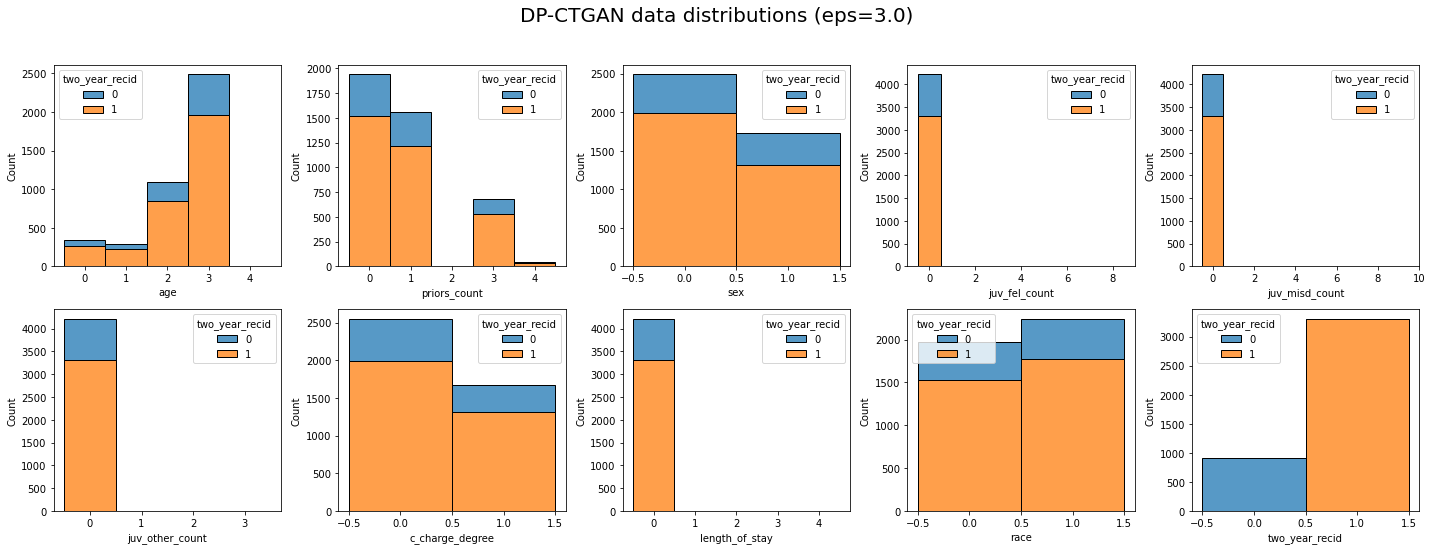

In [20]:
DPCTGAN_eps3_rep0 = pd.read_csv("compas/DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset="compas")

In [21]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.715


In [22]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.016
FPR difference median: 0.012
F1-score median: 0.712


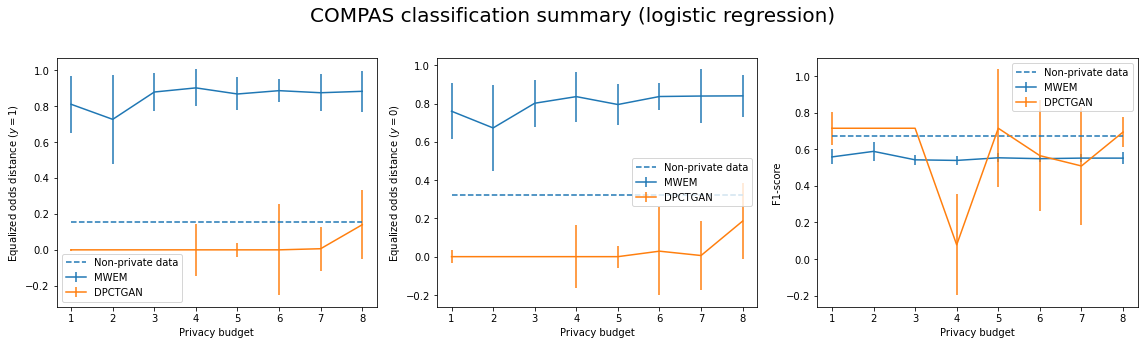

In [23]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

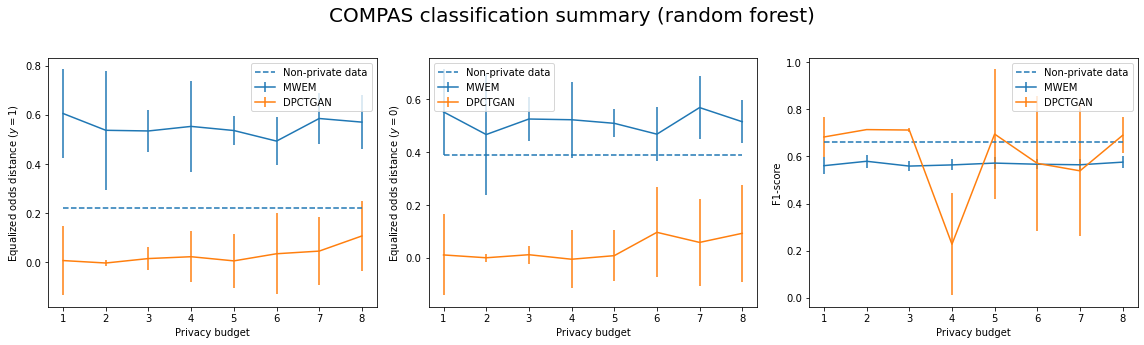

In [24]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

# 5. New PATE-CTGAN synthesis (tuning)

In [25]:
# Set range of epsilon values
epsilon_vals = [3.0]

In [27]:
# Generate 10 repetitions of synthetic data with PATECTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="compas", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5, results_dir="compas/")

Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.


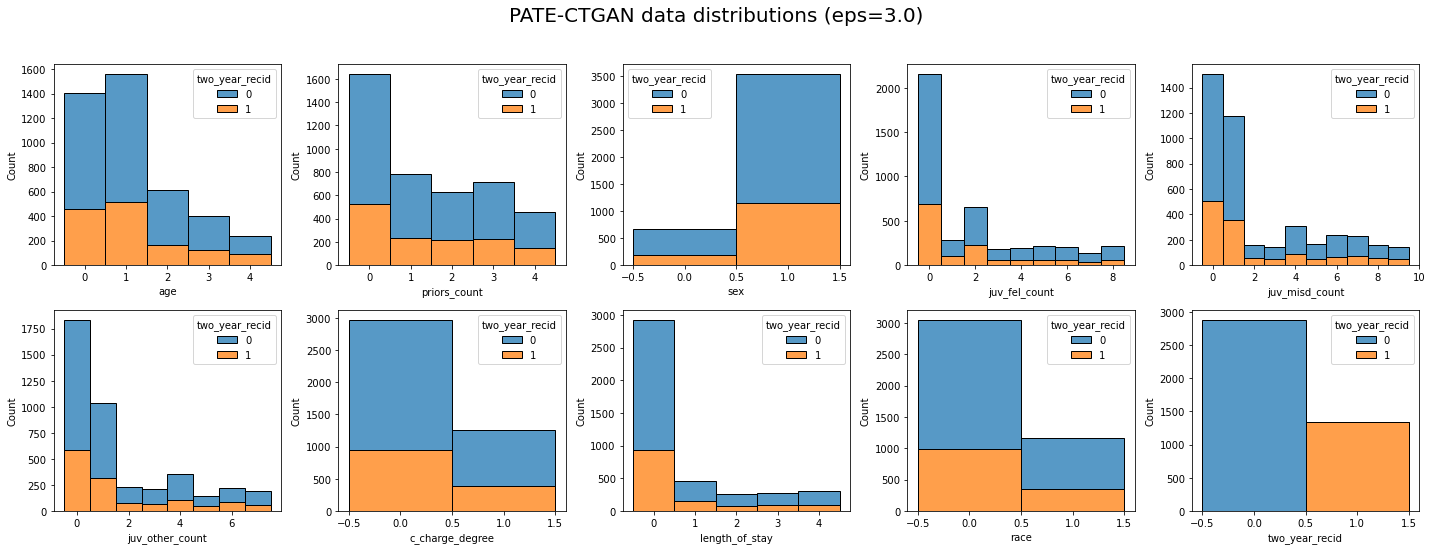

In [31]:
# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("compas/PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)", dataset="compas")

In [32]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [33]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.128
FPR difference median: 0.144
F1-score median: 0.315


In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=200, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=64, generator_dim=(128,128), discriminator_dim=(128,128), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=32, generator_dim=(64,64), discriminator_dim=(64,64), batch_size=100, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

# 6. New QUAIL-MWEM synthesis

In [53]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [35]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

In [36]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.101
FPR difference median: 0.151
F1-score median: 0.637


In [37]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.107
FPR difference median: 0.160
F1-score median: 0.609


# 7. New QUAIL-DPCTGAN synthesis

In [54]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Epoch 1, Loss G: 0.6683, Loss D: 1.3854
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=1.
Epoch 1, Loss G: 0.6722, Loss D: 1.3907
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=2.
Epoch 1, Loss G: 0.6714, Loss D: 1.3811
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=3.
Epoch 1, Loss G: 0.6703, Loss D: 1.3853
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=4.
Epoch 1, Loss G: 0.6702, Loss D: 1.3843
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=5.
Epoch 1, Loss G: 0.6718, Loss D: 1.3809
epsilon is 0.11914420085066957, alpha is 63.0
Completed eps=2.0, rep=6.
Epoch 1, Loss G: 0.6726, Loss D: 1.3861
epsilon is 0.11914420085066

Epoch 2, Loss G: 0.6671, Loss D: 1.3787
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6667, Loss D: 1.3744
epsilon is 0.5937816873875195, alpha is 29.0
Completed eps=7.0, rep=3.
Epoch 1, Loss G: 0.6702, Loss D: 1.3833
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6656, Loss D: 1.3855
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6626, Loss D: 1.3778
epsilon is 0.5937816873875195, alpha is 29.0
Completed eps=7.0, rep=4.
Epoch 1, Loss G: 0.6713, Loss D: 1.3824
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6641, Loss D: 1.3814
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6617, Loss D: 1.3800
epsilon is 0.5937816873875195, alpha is 29.0
Completed eps=7.0, rep=5.
Epoch 1, Loss G: 0.6721, Loss D: 1.3852
epsilon is 0.11914420085066957, alpha is 63.0
Epoch 2, Loss G: 0.6630, Loss D: 1.3768
epsilon is 0.42136662504479083, alpha is 38.0
Epoch 3, Loss G: 0.6629, Loss D: 1.3771
epsilon is 0.593781687387

In [55]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.093
FPR difference median: 0.017
F1-score median: 0.181


In [56]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.059
FPR difference median: 0.003
F1-score median: 0.244


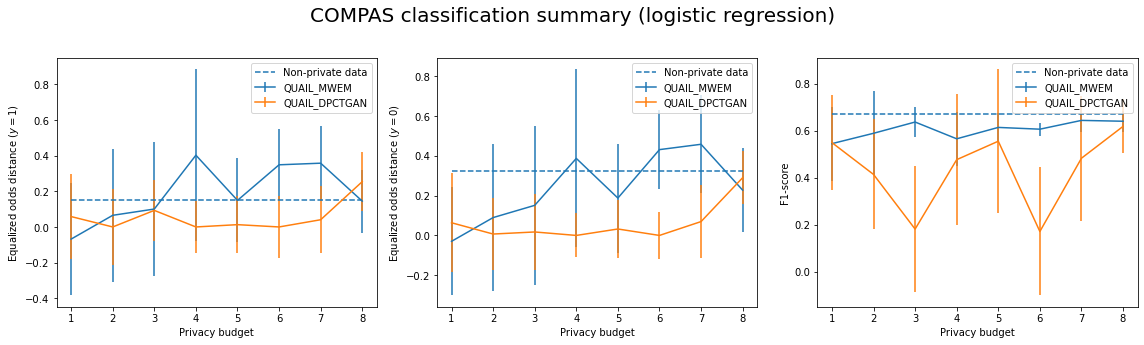

In [57]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

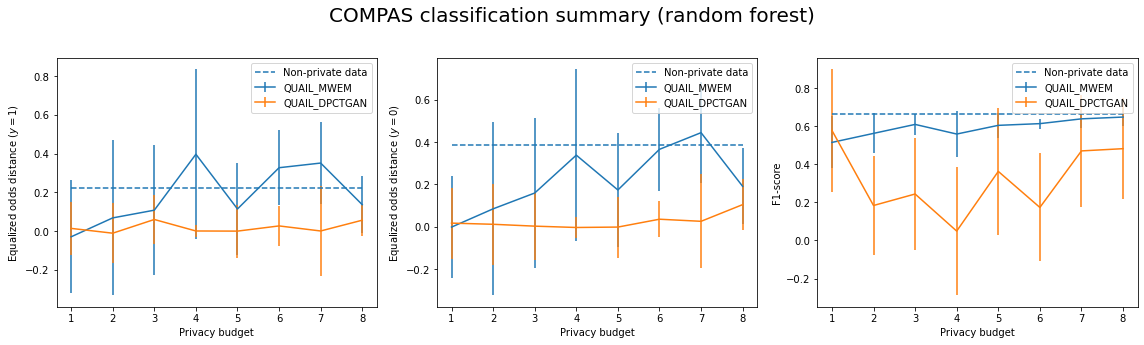

In [58]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

# 8. New QUAIL-PATECTGAN synthesis

In [45]:
# error: epsilon=1.0 too small?
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [46]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed eps=4.0, rep=9.
Completed eps=4.0, rep=10.
Completed eps=5.0, rep=1.
Completed eps=5.0, rep=2.
Completed eps=5.0, rep=3.
Completed eps=5.0, rep=4.
Completed eps=5.0, rep=5.
Completed eps=5.0, rep=6.
Completed eps=5.0, rep=7.
Completed eps=5.0, rep=8.
Completed

In [47]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.133
FPR difference median: 0.117
F1-score median: 0.553


In [48]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.001
FPR difference median: -0.017
F1-score median: 0.290


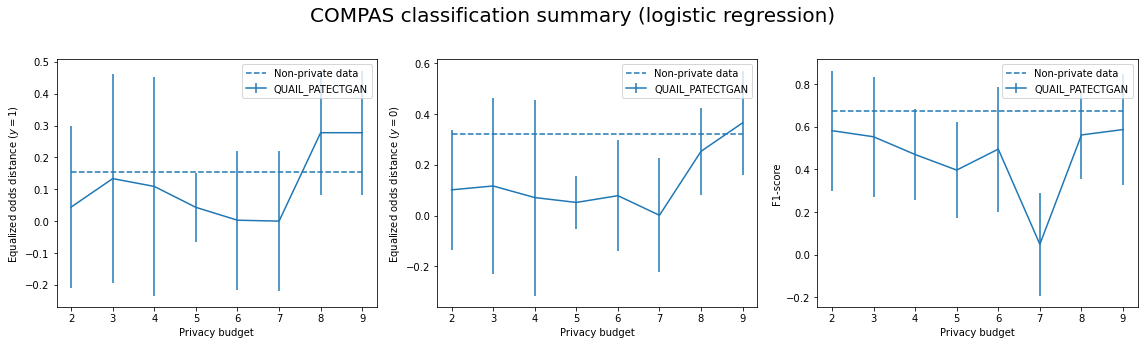

In [49]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

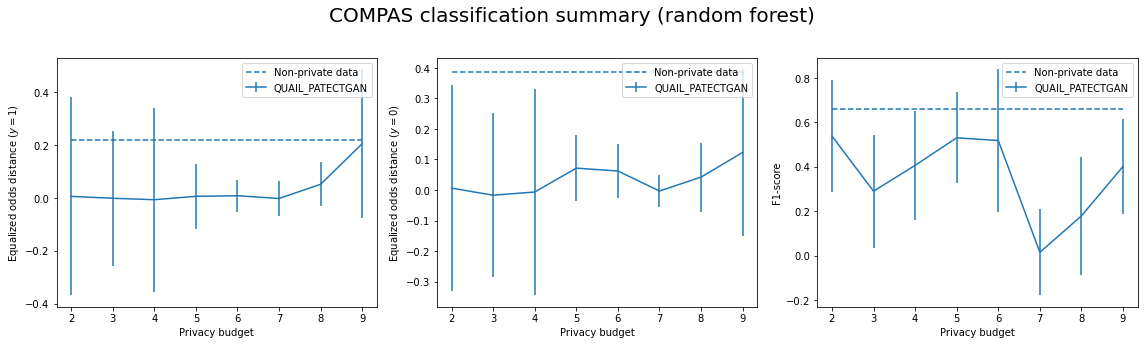

In [50]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

# 9. Comparison to DPLR

In [51]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="compas")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.179
FPR difference median: 0.314
F1-score median: 0.673


# 10. Comparison to k-anonymity

In [7]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [8]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [10]:
# Specify the feature columns and label
feature_columns = ['age','priors_count','sex','juv_fel_count', 'juv_misd_count',
                   'juv_other_count', 'c_charge_degree', 'length_of_stay','race','two_year_recid']
sensitive_column = "two_year_recid"

# Make partitions for k=3
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=3)

# Get the number of partitions created
len(finished_partitions)

350

In [11]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...


In [12]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df, dataset="compas")
kanon_df

,age,priors_count,sex,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,length_of_stay,race,two_year_recid
0,3,1,0,0,0,0,1,0,1,1
1,1,3,1,0,0,3,0,3,0,0
2,1,0,1,0,0,5,1,0,1,0
3,1,0,1,0,0,5,1,0,1,1
4,2,2,1,8,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...
355,1,0,1,2,0,1,0,0,0,0
356,1,0,1,0,0,0,0,0,1,0
357,1,0,1,0,0,1,0,0,1,0
358,1,0,1,0,1,0,0,0,1,0


In [13]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="compas")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Black: 0.5141, White: 0.6903

False positive rates:
Black: 0.2475, White: 0.5361

Equalized odds distances:
y=1: 0.1762, y=0: 0.2886

Classification accuracies:
Black: 0.6302, White: 0.6037

F1-score: 0.6345

Avg train pred: 0.2278, Avg test pred: 0.4858


# 11. Pre-processing (undersampling before synth)

In [14]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

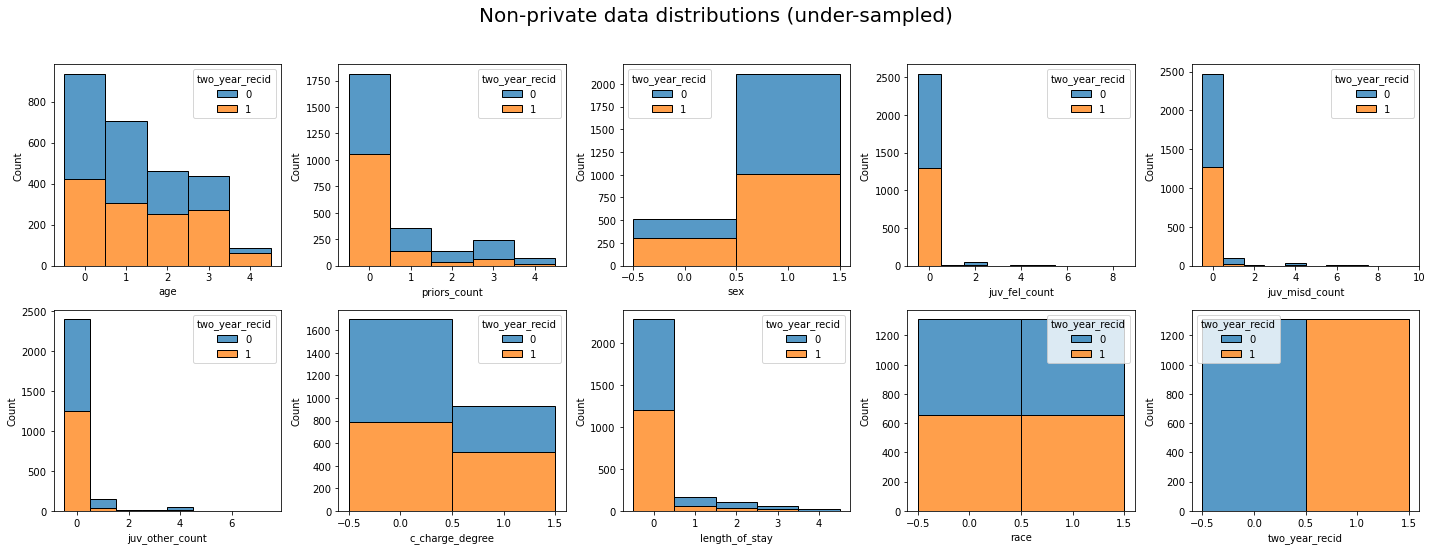

In [16]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="race", target="two_year_recid")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", dataset="compas")

In [17]:
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [18]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

In [19]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Epoch 1, Loss G: 0.6748, Loss D: 1.3718
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=1.
Epoch 1, Loss G: 0.6779, Loss D: 1.3746
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=2.
Epoch 1, Loss G: 0.6737, Loss D: 1.3701
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=3.
Epoch 1, Loss G: 0.6749, Loss D: 1.3698
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=4.
Epoch 1, Loss G: 0.6763, Loss D: 1.3723
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=5.
Epoch 1, Loss G: 0.6759, Loss D: 1.3728
epsilon is 0.10763752960040457, alpha is 63.0
Completed eps=2.0, rep=6.
Epoch 1, Loss G: 0.6760, Loss D: 1.3735
epsilon is 0.10763752960040

epsilon is 0.5282010416846812, alpha is 29.0
Completed eps=7.0, rep=8.
Epoch 1, Loss G: 0.6780, Loss D: 1.3725
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6716, Loss D: 1.3705
epsilon is 0.5282010416846812, alpha is 29.0
Completed eps=7.0, rep=9.
Epoch 1, Loss G: 0.6753, Loss D: 1.3772
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6719, Loss D: 1.3719
epsilon is 0.5282010416846812, alpha is 29.0
Completed eps=7.0, rep=10.
Epoch 1, Loss G: 0.6761, Loss D: 1.3718
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6724, Loss D: 1.3755
epsilon is 0.5282010416846812, alpha is 29.0
Completed eps=8.0, rep=1.
Epoch 1, Loss G: 0.6771, Loss D: 1.3704
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6691, Loss D: 1.3702
epsilon is 0.5282010416846812, alpha is 29.0
Completed eps=8.0, rep=2.
Epoch 1, Loss G: 0.6744, Loss D: 1.3713
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6710, Loss D: 1.3723
epsilon is 0.5

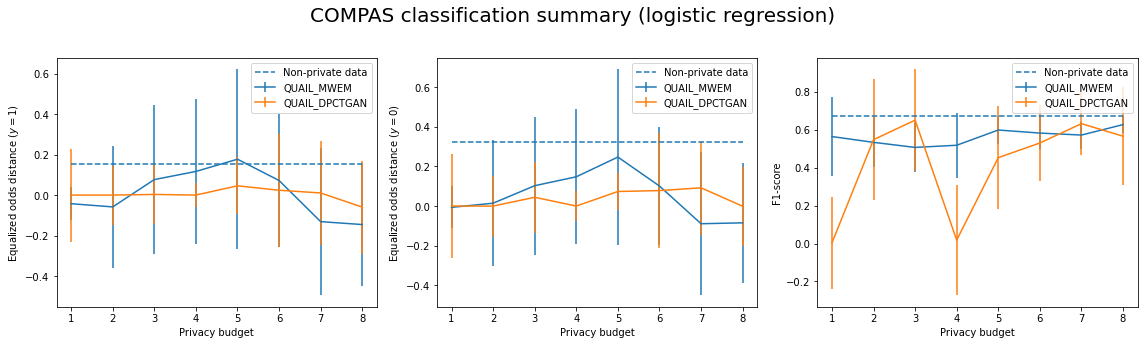

In [20]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")

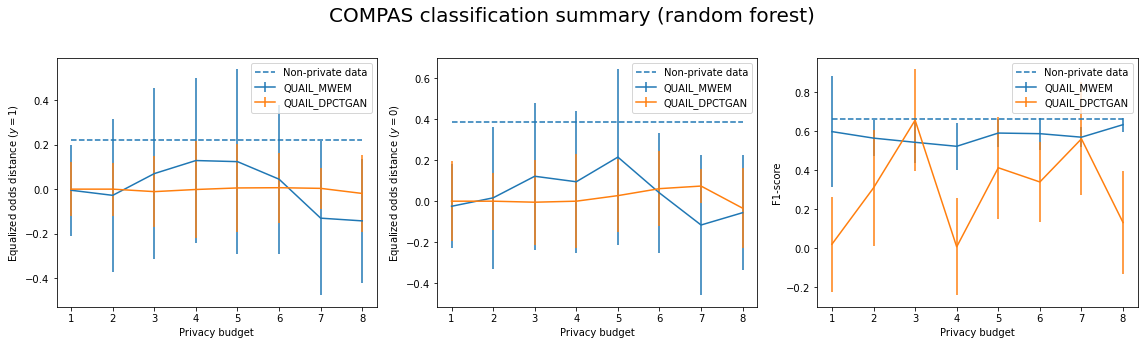

In [21]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")

In [22]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

In [23]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

Epoch 1, Loss G: 0.6783, Loss D: 1.3806
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6722, Loss D: 1.3835
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6724, Loss D: 1.3828
epsilon is 0.7435714503463766, alpha is 22.0
Completed eps=1.0, rep=1.
Epoch 1, Loss G: 0.6740, Loss D: 1.3836
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6709, Loss D: 1.3820
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6680, Loss D: 1.3822
epsilon is 0.7435714503463766, alpha is 22.0
Completed eps=1.0, rep=2.
Epoch 1, Loss G: 0.6749, Loss D: 1.3831
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6733, Loss D: 1.3831
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6706, Loss D: 1.3830
epsilon is 0.7435714503463766, alpha is 22.0
Completed eps=1.0, rep=3.
Epoch 1, Loss G: 0.6743, Loss D: 1.3847
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6729, Loss D: 1.3842
epsilon is 0.528201041684681

Epoch 3, Loss G: 0.6694, Loss D: 1.3819
epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6677, Loss D: 1.3807
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6656, Loss D: 1.3739
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6662, Loss D: 1.3747
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6619, Loss D: 1.3713
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6598, Loss D: 1.3693
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6547, Loss D: 1.3732
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6507, Loss D: 1.3682
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6493, Loss D: 1.3746
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6436, Loss D: 1.3769
epsilon is 1.7967691534837202, alpha is 10.9
Completed eps=2.0, rep=6.
Epoch 1, Loss G: 0.6753, Loss D: 1.3891
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6738, Loss D: 1.3

epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6394, Loss D: 1.3811
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6359, Loss D: 1.3788
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6357, Loss D: 1.3886
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6349, Loss D: 1.3871
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6296, Loss D: 1.3911
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6287, Loss D: 1.3881
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6321, Loss D: 1.3968
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6288, Loss D: 1.3977
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6306, Loss D: 1.3999
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6298, Loss D: 1.3977
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6299, Loss D: 1.3971
epsilon is 2.671711065225949, alpha is 8.2
Completed eps=3.0, rep=2.
E

Epoch 13, Loss G: 0.6444, Loss D: 1.3808
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6389, Loss D: 1.3803
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6371, Loss D: 1.3831
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6358, Loss D: 1.3876
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6318, Loss D: 1.3890
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6323, Loss D: 1.3909
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6305, Loss D: 1.3884
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6267, Loss D: 1.3956
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6269, Loss D: 1.3905
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6311, Loss D: 1.3927
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6268, Loss D: 1.3950
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6294, Loss D: 1.3938
epsilon is 2.671711065225949,

epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6373, Loss D: 1.3794
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6374, Loss D: 1.3803
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6374, Loss D: 1.3850
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6333, Loss D: 1.3853
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6308, Loss D: 1.3850
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6262, Loss D: 1.3903
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6289, Loss D: 1.3901
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6244, Loss D: 1.3940
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6219, Loss D: 1.3988
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6266, Loss D: 1.3974
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6251, Loss D: 1.3959
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6247,

epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6686, Loss D: 1.3745
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6645, Loss D: 1.3734
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6645, Loss D: 1.3773
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6597, Loss D: 1.3761
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6584, Loss D: 1.3704
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6540, Loss D: 1.3706
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6507, Loss D: 1.3712
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6469, Loss D: 1.3763
epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6422, Loss D: 1.3742
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6412, Loss D: 1.3803
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6390, Loss D: 1.3853
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss 

Epoch 21, Loss G: 0.6288, Loss D: 1.3942
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6291, Loss D: 1.3938
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6291, Loss D: 1.3971
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6282, Loss D: 1.3946
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6303, Loss D: 1.3986
epsilon is 2.7344116350282692, alpha is 8.1
Epoch 26, Loss G: 0.6310, Loss D: 1.3985
epsilon is 2.79597173396733, alpha is 7.9
Epoch 27, Loss G: 0.6298, Loss D: 1.3965
epsilon is 2.8564777390015146, alpha is 7.8
Epoch 28, Loss G: 0.6277, Loss D: 1.3924
epsilon is 2.916042618505385, alpha is 7.7
Epoch 29, Loss G: 0.6324, Loss D: 1.4002
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6300, Loss D: 1.3947
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6299, Loss D: 1.3995
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6280, Loss D: 1.4011
epsilon is 3.1455898782866383, a

epsilon is 3.41586893562857, alpha is 6.9
Epoch 38, Loss G: 0.6417, Loss D: 1.3943
epsilon is 3.4679340160278573, alpha is 6.8
Epoch 39, Loss G: 0.6387, Loss D: 1.3906
epsilon is 3.519500390802308, alpha is 6.7
Epoch 40, Loss G: 0.6410, Loss D: 1.3978
epsilon is 3.5706293274105296, alpha is 6.6
Completed eps=4.0, rep=7.
Epoch 1, Loss G: 0.6739, Loss D: 1.3840
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6728, Loss D: 1.3838
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6700, Loss D: 1.3792
epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6688, Loss D: 1.3799
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6668, Loss D: 1.3759
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6660, Loss D: 1.3756
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6612, Loss D: 1.3702
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6611, Loss D: 1.3713
epsilon is 1.4154088514157834, alpha is 13

epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6449, Loss D: 1.3763
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6374, Loss D: 1.3864
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6377, Loss D: 1.3846
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6334, Loss D: 1.3927
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6316, Loss D: 1.3856
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6298, Loss D: 1.3919
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6303, Loss D: 1.3938
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6271, Loss D: 1.3936
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6256, Loss D: 1.3951
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6275, Loss D: 1.3981
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6306, Loss D: 1.3975
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6282, L

Epoch 10, Loss G: 0.6531, Loss D: 1.3752
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6526, Loss D: 1.3709
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6477, Loss D: 1.3759
epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6424, Loss D: 1.3784
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6436, Loss D: 1.3813
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6401, Loss D: 1.3823
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6330, Loss D: 1.3883
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6336, Loss D: 1.3883
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6328, Loss D: 1.3918
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6294, Loss D: 1.3928
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6284, Loss D: 1.3935
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6271, Loss D: 1.3965
epsilon is 2.476431958846

Epoch 47, Loss G: 0.6451, Loss D: 1.3966
epsilon is 3.913644958080232, alpha is 6.2
Epoch 48, Loss G: 0.6464, Loss D: 1.3958
epsilon is 3.9608082181746442, alpha is 6.2
Epoch 49, Loss G: 0.6455, Loss D: 1.3966
epsilon is 4.007669419701622, alpha is 6.1
Epoch 50, Loss G: 0.6471, Loss D: 1.3934
epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6441, Loss D: 1.3932
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6486, Loss D: 1.3950
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6490, Loss D: 1.3943
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6484, Loss D: 1.3910
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6483, Loss D: 1.3896
epsilon is 4.28078542528879, alpha is 5.9
Epoch 56, Loss G: 0.6478, Loss D: 1.3920
epsilon is 4.324928908085401, alpha is 5.8
Epoch 57, Loss G: 0.6465, Loss D: 1.3909
epsilon is 4.368933436682111, alpha is 5.8
Epoch 58, Loss G: 0.6447, Loss D: 1.3983
epsilon is 4.412665429607319, alpha

epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6268, Loss D: 1.3938
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6257, Loss D: 1.3967
epsilon is 2.7344116350282692, alpha is 8.1
Epoch 26, Loss G: 0.6259, Loss D: 1.4004
epsilon is 2.79597173396733, alpha is 7.9
Epoch 27, Loss G: 0.6272, Loss D: 1.3968
epsilon is 2.8564777390015146, alpha is 7.8
Epoch 28, Loss G: 0.6259, Loss D: 1.3992
epsilon is 2.916042618505385, alpha is 7.7
Epoch 29, Loss G: 0.6232, Loss D: 1.4032
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6244, Loss D: 1.4015
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6271, Loss D: 1.4010
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6308, Loss D: 1.3973
epsilon is 3.1455898782866383, alpha is 7.3
Epoch 33, Loss G: 0.6286, Loss D: 1.4012
epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6281, Loss D: 1.3984
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6290, Los

epsilon is 4.499100354576965, alpha is 5.7
Completed eps=5.0, rep=6.
Epoch 1, Loss G: 0.6763, Loss D: 1.3848
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6713, Loss D: 1.3828
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6708, Loss D: 1.3835
epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6687, Loss D: 1.3777
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6660, Loss D: 1.3748
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6651, Loss D: 1.3717
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6646, Loss D: 1.3708
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6625, Loss D: 1.3696
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6593, Loss D: 1.3704
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6564, Loss D: 1.3695
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6500, Loss D: 1.3742
epsilon is 1.710123838759546, alpha is

Epoch 37, Loss G: 0.6372, Loss D: 1.3934
epsilon is 3.41586893562857, alpha is 6.9
Epoch 38, Loss G: 0.6410, Loss D: 1.3932
epsilon is 3.4679340160278573, alpha is 6.8
Epoch 39, Loss G: 0.6383, Loss D: 1.3948
epsilon is 3.519500390802308, alpha is 6.7
Epoch 40, Loss G: 0.6410, Loss D: 1.3941
epsilon is 3.5706293274105296, alpha is 6.6
Epoch 41, Loss G: 0.6419, Loss D: 1.3899
epsilon is 3.620968192999662, alpha is 6.6
Epoch 42, Loss G: 0.6402, Loss D: 1.3958
epsilon is 3.670929761261126, alpha is 6.5
Epoch 43, Loss G: 0.6404, Loss D: 1.3946
epsilon is 3.7204731342295925, alpha is 6.5
Epoch 44, Loss G: 0.6432, Loss D: 1.3993
epsilon is 3.7693397207269315, alpha is 6.4
Epoch 45, Loss G: 0.6423, Loss D: 1.3985
epsilon is 3.817982223102436, alpha is 6.3
Epoch 46, Loss G: 0.6431, Loss D: 1.3981
epsilon is 3.865937795996061, alpha is 6.3
Epoch 47, Loss G: 0.6421, Loss D: 1.3988
epsilon is 3.913644958080232, alpha is 6.2
Epoch 48, Loss G: 0.6439, Loss D: 1.3977
epsilon is 3.9608082181746442, a

epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6414, Loss D: 1.3809
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6354, Loss D: 1.3825
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6342, Loss D: 1.3859
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6335, Loss D: 1.3918
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6296, Loss D: 1.3903
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6290, Loss D: 1.3915
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6298, Loss D: 1.3897
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6268, Loss D: 1.3917
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6234, Loss D: 1.3976
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6265, Loss D: 1.3920
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6274, Loss D: 1.3967
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6260, L

epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6429, Loss D: 1.3953
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6461, Loss D: 1.3863
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6428, Loss D: 1.3954
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6449, Loss D: 1.3967
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6456, Loss D: 1.3924
epsilon is 4.28078542528879, alpha is 5.9
Epoch 56, Loss G: 0.6447, Loss D: 1.3912
epsilon is 4.324928908085401, alpha is 5.8
Epoch 57, Loss G: 0.6443, Loss D: 1.3960
epsilon is 4.368933436682111, alpha is 5.8
Epoch 58, Loss G: 0.6451, Loss D: 1.3946
epsilon is 4.412665429607319, alpha is 5.7
Epoch 59, Loss G: 0.6430, Loss D: 1.3932
epsilon is 4.455882892092143, alpha is 5.7
Epoch 60, Loss G: 0.6430, Loss D: 1.3966
epsilon is 4.499100354576965, alpha is 5.7
Epoch 61, Loss G: 0.6465, Loss D: 1.3931
epsilon is 4.541766439079746, alpha is 5.6
Epoch 62, Loss G: 0.6451, Loss D: 

epsilon is 4.710021045414065, alpha is 5.5
Epoch 66, Loss G: 0.6449, Loss D: 1.3933
epsilon is 4.751667497501167, alpha is 5.5
Epoch 67, Loss G: 0.6489, Loss D: 1.3928
epsilon is 4.792649798924569, alpha is 5.4
Epoch 68, Loss G: 0.6501, Loss D: 1.3920
epsilon is 4.83351230153953, alpha is 5.4
Epoch 69, Loss G: 0.6515, Loss D: 1.3892
epsilon is 4.874374804154492, alpha is 5.4
Epoch 70, Loss G: 0.6499, Loss D: 1.3895
epsilon is 4.914766184396738, alpha is 5.3
Epoch 71, Loss G: 0.6534, Loss D: 1.3889
epsilon is 4.954845771249317, alpha is 5.3
Epoch 72, Loss G: 0.6524, Loss D: 1.3920
epsilon is 4.994925358101894, alpha is 5.3
Epoch 73, Loss G: 0.6524, Loss D: 1.3903
epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6547, Loss D: 1.3885
epsilon is 5.074211519589549, alpha is 5.2
Epoch 75, Loss G: 0.6525, Loss D: 1.3906
epsilon is 5.113509221820532, alpha is 5.2
Epoch 76, Loss G: 0.6518, Loss D: 1.3920
epsilon is 5.152806924051514, alpha is 5.2
Epoch 77, Loss G: 0.6531, Loss D: 

epsilon is 5.30736805996754, alpha is 5.1
Epoch 81, Loss G: 0.6558, Loss D: 1.3915
epsilon is 5.345628946406895, alpha is 5.0
Epoch 82, Loss G: 0.6573, Loss D: 1.3912
epsilon is 5.383365962588839, alpha is 5.0
Completed eps=6.0, rep=3.
Epoch 1, Loss G: 0.6749, Loss D: 1.3842
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6717, Loss D: 1.3848
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6722, Loss D: 1.3815
epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6686, Loss D: 1.3761
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6666, Loss D: 1.3790
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6658, Loss D: 1.3727
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6645, Loss D: 1.3745
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6586, Loss D: 1.3742
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6552, Loss D: 1.3742
epsilon is 1.5190003435757524, alpha is 13.

Epoch 13, Loss G: 0.6431, Loss D: 1.3786
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6403, Loss D: 1.3857
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6376, Loss D: 1.3853
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6381, Loss D: 1.3825
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6350, Loss D: 1.3878
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6313, Loss D: 1.3916
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6332, Loss D: 1.3934
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6320, Loss D: 1.3952
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6325, Loss D: 1.3918
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6318, Loss D: 1.3949
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6279, Loss D: 1.3952
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6315, Loss D: 1.3928
epsilon is 2.671711065225949,

Epoch 28, Loss G: 0.6256, Loss D: 1.3992
epsilon is 2.916042618505385, alpha is 7.7
Epoch 29, Loss G: 0.6267, Loss D: 1.3984
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6256, Loss D: 1.3960
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6262, Loss D: 1.4022
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6272, Loss D: 1.3966
epsilon is 3.1455898782866383, alpha is 7.3
Epoch 33, Loss G: 0.6284, Loss D: 1.3989
epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6285, Loss D: 1.3970
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6306, Loss D: 1.3987
epsilon is 3.309716297834346, alpha is 7.0
Epoch 36, Loss G: 0.6298, Loss D: 1.3957
epsilon is 3.3631371895607924, alpha is 6.9
Epoch 37, Loss G: 0.6308, Loss D: 1.4004
epsilon is 3.41586893562857, alpha is 6.9
Epoch 38, Loss G: 0.6362, Loss D: 1.3979
epsilon is 3.4679340160278573, alpha is 6.8
Epoch 39, Loss G: 0.6352, Loss D: 1.3944
epsilon is 3.519500390802308, a

Epoch 43, Loss G: 0.6415, Loss D: 1.3911
epsilon is 3.7204731342295925, alpha is 6.5
Epoch 44, Loss G: 0.6442, Loss D: 1.3980
epsilon is 3.7693397207269315, alpha is 6.4
Epoch 45, Loss G: 0.6400, Loss D: 1.3965
epsilon is 3.817982223102436, alpha is 6.3
Epoch 46, Loss G: 0.6420, Loss D: 1.3980
epsilon is 3.865937795996061, alpha is 6.3
Epoch 47, Loss G: 0.6379, Loss D: 1.3987
epsilon is 3.913644958080232, alpha is 6.2
Epoch 48, Loss G: 0.6437, Loss D: 1.3998
epsilon is 3.9608082181746442, alpha is 6.2
Epoch 49, Loss G: 0.6389, Loss D: 1.3992
epsilon is 4.007669419701622, alpha is 6.1
Epoch 50, Loss G: 0.6407, Loss D: 1.3981
epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6427, Loss D: 1.3973
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6460, Loss D: 1.3919
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6491, Loss D: 1.3921
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6479, Loss D: 1.3909
epsilon is 4.235992786497683, al

Epoch 58, Loss G: 0.6478, Loss D: 1.3932
epsilon is 4.412665429607319, alpha is 5.7
Epoch 59, Loss G: 0.6440, Loss D: 1.3974
epsilon is 4.455882892092143, alpha is 5.7
Epoch 60, Loss G: 0.6464, Loss D: 1.3943
epsilon is 4.499100354576965, alpha is 5.7
Epoch 61, Loss G: 0.6466, Loss D: 1.4009
epsilon is 4.541766439079746, alpha is 5.6
Epoch 62, Loss G: 0.6477, Loss D: 1.3945
epsilon is 4.584197876927369, alpha is 5.6
Epoch 63, Loss G: 0.6471, Loss D: 1.3941
epsilon is 4.626629314774991, alpha is 5.6
Epoch 64, Loss G: 0.6506, Loss D: 1.3970
epsilon is 4.668374593326963, alpha is 5.5
Epoch 65, Loss G: 0.6514, Loss D: 1.3951
epsilon is 4.710021045414065, alpha is 5.5
Epoch 66, Loss G: 0.6494, Loss D: 1.3857
epsilon is 4.751667497501167, alpha is 5.5
Epoch 67, Loss G: 0.6524, Loss D: 1.3889
epsilon is 4.792649798924569, alpha is 5.4
Epoch 68, Loss G: 0.6548, Loss D: 1.3887
epsilon is 4.83351230153953, alpha is 5.4
Epoch 69, Loss G: 0.6531, Loss D: 1.3901
epsilon is 4.874374804154492, alpha 

Epoch 73, Loss G: 0.6442, Loss D: 1.3951
epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6449, Loss D: 1.3968
epsilon is 5.074211519589549, alpha is 5.2
Epoch 75, Loss G: 0.6442, Loss D: 1.3943
epsilon is 5.113509221820532, alpha is 5.2
Epoch 76, Loss G: 0.6480, Loss D: 1.3975
epsilon is 5.152806924051514, alpha is 5.2
Epoch 77, Loss G: 0.6478, Loss D: 1.3880
epsilon is 5.191817521395296, alpha is 5.1
Epoch 78, Loss G: 0.6511, Loss D: 1.3903
epsilon is 5.230334367586043, alpha is 5.1
Epoch 79, Loss G: 0.6507, Loss D: 1.3893
epsilon is 5.268851213776792, alpha is 5.1
Epoch 80, Loss G: 0.6523, Loss D: 1.3905
epsilon is 5.30736805996754, alpha is 5.1
Epoch 81, Loss G: 0.6491, Loss D: 1.3850
epsilon is 5.345628946406895, alpha is 5.0
Epoch 82, Loss G: 0.6462, Loss D: 1.3893
epsilon is 5.383365962588839, alpha is 5.0
Completed eps=6.0, rep=9.
Epoch 1, Loss G: 0.6761, Loss D: 1.3869
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6712, Loss D: 1.3805
epsilon i

Epoch 6, Loss G: 0.6652, Loss D: 1.3738
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6645, Loss D: 1.3755
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6600, Loss D: 1.3703
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6576, Loss D: 1.3691
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6562, Loss D: 1.3741
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6494, Loss D: 1.3713
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6441, Loss D: 1.3728
epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6418, Loss D: 1.3756
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6393, Loss D: 1.3783
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6353, Loss D: 1.3859
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6322, Loss D: 1.3858
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6322, Loss D: 1.3938
epsilon is 2.1952981

epsilon is 6.14320905007302, alpha is 4.6
Epoch 104, Loss G: 0.6570, Loss D: 1.3902
epsilon is 6.177836955867085, alpha is 4.6
Epoch 105, Loss G: 0.6551, Loss D: 1.3911
epsilon is 6.21246486166115, alpha is 4.6
Epoch 106, Loss G: 0.6552, Loss D: 1.3862
epsilon is 6.247092767455215, alpha is 4.6
Epoch 107, Loss G: 0.6559, Loss D: 1.3907
epsilon is 6.281294333232687, alpha is 4.5
Completed eps=7.0, rep=1.
Epoch 1, Loss G: 0.6750, Loss D: 1.3837
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6721, Loss D: 1.3806
epsilon is 0.5282010416846812, alpha is 29.0
Epoch 3, Loss G: 0.6683, Loss D: 1.3803
epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6683, Loss D: 1.3764
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6645, Loss D: 1.3727
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6643, Loss D: 1.3763
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6634, Loss D: 1.3745
epsilon is 1.3053909513414876, alpha is 14

epsilon is 5.789738589556053, alpha is 4.8
Epoch 94, Loss G: 0.6608, Loss D: 1.3882
epsilon is 5.825919013662519, alpha is 4.8
Epoch 95, Loss G: 0.6599, Loss D: 1.3912
epsilon is 5.861989801884509, alpha is 4.7
Epoch 96, Loss G: 0.6560, Loss D: 1.3889
epsilon is 5.897393458871675, alpha is 4.7
Epoch 97, Loss G: 0.6559, Loss D: 1.3879
epsilon is 5.932797115858841, alpha is 4.7
Epoch 98, Loss G: 0.6573, Loss D: 1.3893
epsilon is 5.968200772846007, alpha is 4.7
Epoch 99, Loss G: 0.6556, Loss D: 1.3893
epsilon is 6.003604429833174, alpha is 4.7
Epoch 100, Loss G: 0.6540, Loss D: 1.3923
epsilon is 6.039008086820339, alpha is 4.7
Epoch 101, Loss G: 0.6502, Loss D: 1.3918
epsilon is 6.073953238484889, alpha is 4.6
Epoch 102, Loss G: 0.6527, Loss D: 1.3936
epsilon is 6.108581144278955, alpha is 4.6
Epoch 103, Loss G: 0.6584, Loss D: 1.3897
epsilon is 6.14320905007302, alpha is 4.6
Epoch 104, Loss G: 0.6603, Loss D: 1.3862
epsilon is 6.177836955867085, alpha is 4.6
Epoch 105, Loss G: 0.6602, Lo

epsilon is 5.421102978770786, alpha is 5.0
Epoch 84, Loss G: 0.6595, Loss D: 1.3870
epsilon is 5.45883999495273, alpha is 5.0
Epoch 85, Loss G: 0.6591, Loss D: 1.3862
epsilon is 5.496577011134677, alpha is 5.0
Epoch 86, Loss G: 0.6625, Loss D: 1.3844
epsilon is 5.533560328444531, alpha is 4.9
Epoch 87, Loss G: 0.6613, Loss D: 1.3846
epsilon is 5.5705185381087245, alpha is 4.9
Epoch 88, Loss G: 0.6600, Loss D: 1.3919
epsilon is 5.6074767477729175, alpha is 4.9
Epoch 89, Loss G: 0.6557, Loss D: 1.3914
epsilon is 5.64443495743711, alpha is 4.9
Epoch 90, Loss G: 0.6580, Loss D: 1.3883
epsilon is 5.681197317236654, alpha is 4.8
Epoch 91, Loss G: 0.6513, Loss D: 1.3953
epsilon is 5.71737774134312, alpha is 4.8
Epoch 92, Loss G: 0.6532, Loss D: 1.3964
epsilon is 5.753558165449586, alpha is 4.8
Epoch 93, Loss G: 0.6501, Loss D: 1.3940
epsilon is 5.789738589556053, alpha is 4.8
Epoch 94, Loss G: 0.6500, Loss D: 1.3953
epsilon is 5.825919013662519, alpha is 4.8
Epoch 95, Loss G: 0.6561, Loss D: 

epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6526, Loss D: 1.3939
epsilon is 5.074211519589549, alpha is 5.2
Epoch 75, Loss G: 0.6526, Loss D: 1.3958
epsilon is 5.113509221820532, alpha is 5.2
Epoch 76, Loss G: 0.6540, Loss D: 1.3951
epsilon is 5.152806924051514, alpha is 5.2
Epoch 77, Loss G: 0.6573, Loss D: 1.3949
epsilon is 5.191817521395296, alpha is 5.1
Epoch 78, Loss G: 0.6557, Loss D: 1.3940
epsilon is 5.230334367586043, alpha is 5.1
Epoch 79, Loss G: 0.6533, Loss D: 1.3910
epsilon is 5.268851213776792, alpha is 5.1
Epoch 80, Loss G: 0.6555, Loss D: 1.3930
epsilon is 5.30736805996754, alpha is 5.1
Epoch 81, Loss G: 0.6583, Loss D: 1.3902
epsilon is 5.345628946406895, alpha is 5.0
Epoch 82, Loss G: 0.6584, Loss D: 1.3890
epsilon is 5.383365962588839, alpha is 5.0
Epoch 83, Loss G: 0.6581, Loss D: 1.3908
epsilon is 5.421102978770786, alpha is 5.0
Epoch 84, Loss G: 0.6590, Loss D: 1.3912
epsilon is 5.45883999495273, alpha is 5.0
Epoch 85, Loss G: 0.6623, Loss D: 1

epsilon is 4.626629314774991, alpha is 5.6
Epoch 64, Loss G: 0.6516, Loss D: 1.3888
epsilon is 4.668374593326963, alpha is 5.5
Epoch 65, Loss G: 0.6531, Loss D: 1.3889
epsilon is 4.710021045414065, alpha is 5.5
Epoch 66, Loss G: 0.6507, Loss D: 1.3880
epsilon is 4.751667497501167, alpha is 5.5
Epoch 67, Loss G: 0.6511, Loss D: 1.3919
epsilon is 4.792649798924569, alpha is 5.4
Epoch 68, Loss G: 0.6490, Loss D: 1.3928
epsilon is 4.83351230153953, alpha is 5.4
Epoch 69, Loss G: 0.6513, Loss D: 1.3973
epsilon is 4.874374804154492, alpha is 5.4
Epoch 70, Loss G: 0.6479, Loss D: 1.3992
epsilon is 4.914766184396738, alpha is 5.3
Epoch 71, Loss G: 0.6514, Loss D: 1.3985
epsilon is 4.954845771249317, alpha is 5.3
Epoch 72, Loss G: 0.6504, Loss D: 1.3945
epsilon is 4.994925358101894, alpha is 5.3
Epoch 73, Loss G: 0.6545, Loss D: 1.3896
epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6578, Loss D: 1.3888
epsilon is 5.074211519589549, alpha is 5.2
Epoch 75, Loss G: 0.6577, Loss D: 

epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6488, Loss D: 1.3968
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6489, Loss D: 1.3867
epsilon is 4.28078542528879, alpha is 5.9
Epoch 56, Loss G: 0.6503, Loss D: 1.3937
epsilon is 4.324928908085401, alpha is 5.8
Epoch 57, Loss G: 0.6541, Loss D: 1.3834
epsilon is 4.368933436682111, alpha is 5.8
Epoch 58, Loss G: 0.6556, Loss D: 1.3844
epsilon is 4.412665429607319, alpha is 5.7
Epoch 59, Loss G: 0.6516, Loss D: 1.3822
epsilon is 4.455882892092143, alpha is 5.7
Epoch 60, Loss G: 0.6504, Loss D: 1.3875
epsilon is 4.499100354576965, alpha is 5.7
Epoch 61, Loss G: 0.6549, Loss D: 1.3864
epsilon is 4.541766439079746, alpha is 5.6
Epoch 62, Loss G: 0.6489, Loss D: 1.3950
epsilon is 4.584197876927369, alpha is 5.6
Epoch 63, Loss G: 0.6485, Loss D: 1.3929
epsilon is 4.626629314774991, alpha is 5.6
Epoch 64, Loss G: 0.6477, Loss D: 1.3952
epsilon is 4.668374593326963, alpha is 5.5
Epoch 65, Loss G: 0.6456, Loss D: 

epsilon is 3.7204731342295925, alpha is 6.5
Epoch 44, Loss G: 0.6440, Loss D: 1.3985
epsilon is 3.7693397207269315, alpha is 6.4
Epoch 45, Loss G: 0.6378, Loss D: 1.3964
epsilon is 3.817982223102436, alpha is 6.3
Epoch 46, Loss G: 0.6401, Loss D: 1.3948
epsilon is 3.865937795996061, alpha is 6.3
Epoch 47, Loss G: 0.6392, Loss D: 1.3991
epsilon is 3.913644958080232, alpha is 6.2
Epoch 48, Loss G: 0.6402, Loss D: 1.3953
epsilon is 3.9608082181746442, alpha is 6.2
Epoch 49, Loss G: 0.6425, Loss D: 1.3912
epsilon is 4.007669419701622, alpha is 6.1
Epoch 50, Loss G: 0.6434, Loss D: 1.3958
epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6469, Loss D: 1.3933
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6448, Loss D: 1.3922
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6460, Loss D: 1.3916
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6467, Loss D: 1.3892
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6466, Loss

epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6321, Loss D: 1.3961
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6352, Loss D: 1.3961
epsilon is 3.309716297834346, alpha is 7.0
Epoch 36, Loss G: 0.6334, Loss D: 1.3945
epsilon is 3.3631371895607924, alpha is 6.9
Epoch 37, Loss G: 0.6377, Loss D: 1.3960
epsilon is 3.41586893562857, alpha is 6.9
Epoch 38, Loss G: 0.6377, Loss D: 1.3877
epsilon is 3.4679340160278573, alpha is 6.8
Epoch 39, Loss G: 0.6365, Loss D: 1.3928
epsilon is 3.519500390802308, alpha is 6.7
Epoch 40, Loss G: 0.6388, Loss D: 1.3966
epsilon is 3.5706293274105296, alpha is 6.6
Epoch 41, Loss G: 0.6398, Loss D: 1.3966
epsilon is 3.620968192999662, alpha is 6.6
Epoch 42, Loss G: 0.6386, Loss D: 1.3956
epsilon is 3.670929761261126, alpha is 6.5
Epoch 43, Loss G: 0.6383, Loss D: 1.3953
epsilon is 3.7204731342295925, alpha is 6.5
Epoch 44, Loss G: 0.6397, Loss D: 1.3957
epsilon is 3.7693397207269315, alpha is 6.4
Epoch 45, Loss G: 0.6416, Lo

epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6285, Loss D: 1.3961
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6260, Loss D: 1.3990
epsilon is 2.7344116350282692, alpha is 8.1
Epoch 26, Loss G: 0.6262, Loss D: 1.3944
epsilon is 2.79597173396733, alpha is 7.9
Epoch 27, Loss G: 0.6271, Loss D: 1.3995
epsilon is 2.8564777390015146, alpha is 7.8
Epoch 28, Loss G: 0.6274, Loss D: 1.3935
epsilon is 2.916042618505385, alpha is 7.7
Epoch 29, Loss G: 0.6265, Loss D: 1.4022
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6292, Loss D: 1.4021
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6325, Loss D: 1.3998
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6336, Loss D: 1.3975
epsilon is 3.1455898782866383, alpha is 7.3
Epoch 33, Loss G: 0.6355, Loss D: 1.3957
epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6366, Loss D: 1.3953
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6384, Los

epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6416, Loss D: 1.3800
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6373, Loss D: 1.3836
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6369, Loss D: 1.3886
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6352, Loss D: 1.3863
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6317, Loss D: 1.3880
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0.6304, Loss D: 1.3890
epsilon is 2.339257615470939, alpha is 9.1
Epoch 20, Loss G: 0.6321, Loss D: 1.3901
epsilon is 2.408627135103968, alpha is 8.9
Epoch 21, Loss G: 0.6280, Loss D: 1.3941
epsilon is 2.476431958846773, alpha is 8.7
Epoch 22, Loss G: 0.6266, Loss D: 1.3920
epsilon is 2.5428196740176423, alpha is 8.5
Epoch 23, Loss G: 0.6272, Loss D: 1.3970
epsilon is 2.607952815062501, alpha is 8.3
Epoch 24, Loss G: 0.6287, Loss D: 1.3964
epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6290, L

epsilon is 0.7435714503463766, alpha is 22.0
Epoch 4, Loss G: 0.6711, Loss D: 1.3737
epsilon is 0.9130120393688285, alpha is 19.0
Epoch 5, Loss G: 0.6680, Loss D: 1.3725
epsilon is 1.0581311337552453, alpha is 17.0
Epoch 6, Loss G: 0.6682, Loss D: 1.3714
epsilon is 1.1873150626560538, alpha is 15.0
Epoch 7, Loss G: 0.6650, Loss D: 1.3698
epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6638, Loss D: 1.3731
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6590, Loss D: 1.3704
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6576, Loss D: 1.3726
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6519, Loss D: 1.3708
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6467, Loss D: 1.3756
epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6438, Loss D: 1.3785
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6407, Loss D: 1.3833
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G

Epoch 101, Loss G: 0.6545, Loss D: 1.3890
epsilon is 6.073953238484889, alpha is 4.6
Epoch 102, Loss G: 0.6530, Loss D: 1.3956
epsilon is 6.108581144278955, alpha is 4.6
Epoch 103, Loss G: 0.6546, Loss D: 1.3920
epsilon is 6.14320905007302, alpha is 4.6
Epoch 104, Loss G: 0.6581, Loss D: 1.3881
epsilon is 6.177836955867085, alpha is 4.6
Epoch 105, Loss G: 0.6575, Loss D: 1.3911
epsilon is 6.21246486166115, alpha is 4.6
Epoch 106, Loss G: 0.6548, Loss D: 1.3911
epsilon is 6.247092767455215, alpha is 4.6
Epoch 107, Loss G: 0.6573, Loss D: 1.3897
epsilon is 6.281294333232687, alpha is 4.5
Epoch 108, Loss G: 0.6565, Loss D: 1.3981
epsilon is 6.315147501256885, alpha is 4.5
Epoch 109, Loss G: 0.6544, Loss D: 1.3903
epsilon is 6.349000669281085, alpha is 4.5
Epoch 110, Loss G: 0.6555, Loss D: 1.3942
epsilon is 6.3828538373052846, alpha is 4.5
Epoch 111, Loss G: 0.6551, Loss D: 1.3967
epsilon is 6.416707005329483, alpha is 4.5
Epoch 112, Loss G: 0.6555, Loss D: 1.3955
epsilon is 6.45056017335

epsilon is 4.584197876927369, alpha is 5.6
Epoch 63, Loss G: 0.6485, Loss D: 1.3990
epsilon is 4.626629314774991, alpha is 5.6
Epoch 64, Loss G: 0.6486, Loss D: 1.3943
epsilon is 4.668374593326963, alpha is 5.5
Epoch 65, Loss G: 0.6476, Loss D: 1.3952
epsilon is 4.710021045414065, alpha is 5.5
Epoch 66, Loss G: 0.6481, Loss D: 1.3938
epsilon is 4.751667497501167, alpha is 5.5
Epoch 67, Loss G: 0.6485, Loss D: 1.3951
epsilon is 4.792649798924569, alpha is 5.4
Epoch 68, Loss G: 0.6512, Loss D: 1.3938
epsilon is 4.83351230153953, alpha is 5.4
Epoch 69, Loss G: 0.6511, Loss D: 1.3919
epsilon is 4.874374804154492, alpha is 5.4
Epoch 70, Loss G: 0.6541, Loss D: 1.3930
epsilon is 4.914766184396738, alpha is 5.3
Epoch 71, Loss G: 0.6541, Loss D: 1.3926
epsilon is 4.954845771249317, alpha is 5.3
Epoch 72, Loss G: 0.6528, Loss D: 1.3918
epsilon is 4.994925358101894, alpha is 5.3
Epoch 73, Loss G: 0.6554, Loss D: 1.3911
epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6589, Loss D: 

epsilon is 2.671711065225949, alpha is 8.2
Epoch 25, Loss G: 0.6277, Loss D: 1.3980
epsilon is 2.7344116350282692, alpha is 8.1
Epoch 26, Loss G: 0.6268, Loss D: 1.3999
epsilon is 2.79597173396733, alpha is 7.9
Epoch 27, Loss G: 0.6281, Loss D: 1.3947
epsilon is 2.8564777390015146, alpha is 7.8
Epoch 28, Loss G: 0.6297, Loss D: 1.3982
epsilon is 2.916042618505385, alpha is 7.7
Epoch 29, Loss G: 0.6279, Loss D: 1.3974
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6320, Loss D: 1.3980
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6333, Loss D: 1.3965
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6322, Loss D: 1.3948
epsilon is 3.1455898782866383, alpha is 7.3
Epoch 33, Loss G: 0.6338, Loss D: 1.3908
epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6387, Loss D: 1.3944
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6382, Loss D: 1.3916
epsilon is 3.309716297834346, alpha is 7.0
Epoch 36, Loss G: 0.6372, Los

Epoch 122, Loss G: 0.6618, Loss D: 1.3854
epsilon is 6.780805055424648, alpha is 4.3
Epoch 123, Loss G: 0.6598, Loss D: 1.3857
epsilon is 6.813111778213163, alpha is 4.3
Epoch 124, Loss G: 0.6576, Loss D: 1.3846
epsilon is 6.845418501001679, alpha is 4.3
Epoch 125, Loss G: 0.6588, Loss D: 1.3851
epsilon is 6.877725223790194, alpha is 4.3
Epoch 126, Loss G: 0.6573, Loss D: 1.3893
epsilon is 6.91003194657871, alpha is 4.3
Epoch 127, Loss G: 0.6595, Loss D: 1.3902
epsilon is 6.942338669367225, alpha is 4.3
Epoch 128, Loss G: 0.6604, Loss D: 1.3847
epsilon is 6.974645392155741, alpha is 4.3
Epoch 129, Loss G: 0.6617, Loss D: 1.3921
epsilon is 7.006297048392985, alpha is 4.2
Epoch 130, Loss G: 0.6600, Loss D: 1.3883
epsilon is 7.037832058755774, alpha is 4.2
Epoch 131, Loss G: 0.6578, Loss D: 1.3904
epsilon is 7.069367069118564, alpha is 4.2
Epoch 132, Loss G: 0.6597, Loss D: 1.3907
epsilon is 7.1009020794813535, alpha is 4.2
Epoch 133, Loss G: 0.6562, Loss D: 1.3954
epsilon is 7.1324370898

Epoch 84, Loss G: 0.6540, Loss D: 1.3942
epsilon is 5.45883999495273, alpha is 5.0
Epoch 85, Loss G: 0.6513, Loss D: 1.3916
epsilon is 5.496577011134677, alpha is 5.0
Epoch 86, Loss G: 0.6516, Loss D: 1.3904
epsilon is 5.533560328444531, alpha is 4.9
Epoch 87, Loss G: 0.6538, Loss D: 1.3900
epsilon is 5.5705185381087245, alpha is 4.9
Epoch 88, Loss G: 0.6517, Loss D: 1.3887
epsilon is 5.6074767477729175, alpha is 4.9
Epoch 89, Loss G: 0.6539, Loss D: 1.3972
epsilon is 5.64443495743711, alpha is 4.9
Epoch 90, Loss G: 0.6528, Loss D: 1.3943
epsilon is 5.681197317236654, alpha is 4.8
Epoch 91, Loss G: 0.6526, Loss D: 1.3925
epsilon is 5.71737774134312, alpha is 4.8
Epoch 92, Loss G: 0.6538, Loss D: 1.3941
epsilon is 5.753558165449586, alpha is 4.8
Epoch 93, Loss G: 0.6539, Loss D: 1.3932
epsilon is 5.789738589556053, alpha is 4.8
Epoch 94, Loss G: 0.6516, Loss D: 1.3942
epsilon is 5.825919013662519, alpha is 4.8
Epoch 95, Loss G: 0.6556, Loss D: 1.3892
epsilon is 5.861989801884509, alpha 

epsilon is 3.817982223102436, alpha is 6.3
Epoch 46, Loss G: 0.6432, Loss D: 1.3927
epsilon is 3.865937795996061, alpha is 6.3
Epoch 47, Loss G: 0.6411, Loss D: 1.3965
epsilon is 3.913644958080232, alpha is 6.2
Epoch 48, Loss G: 0.6414, Loss D: 1.3939
epsilon is 3.9608082181746442, alpha is 6.2
Epoch 49, Loss G: 0.6403, Loss D: 1.3912
epsilon is 4.007669419701622, alpha is 6.1
Epoch 50, Loss G: 0.6424, Loss D: 1.3904
epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6449, Loss D: 1.3934
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6448, Loss D: 1.3883
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6456, Loss D: 1.3890
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6432, Loss D: 1.3932
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6429, Loss D: 1.3945
epsilon is 4.28078542528879, alpha is 5.9
Epoch 56, Loss G: 0.6423, Loss D: 1.3945
epsilon is 4.324928908085401, alpha is 5.8
Epoch 57, Loss G: 0.6416, Loss D:

epsilon is 1.3053909513414876, alpha is 14.0
Epoch 8, Loss G: 0.6584, Loss D: 1.3693
epsilon is 1.4154088514157834, alpha is 13.0
Epoch 9, Loss G: 0.6575, Loss D: 1.3715
epsilon is 1.5190003435757524, alpha is 13.0
Epoch 10, Loss G: 0.6506, Loss D: 1.3755
epsilon is 1.6151719178692463, alpha is 12.0
Epoch 11, Loss G: 0.6496, Loss D: 1.3703
epsilon is 1.710123838759546, alpha is 12.0
Epoch 12, Loss G: 0.6486, Loss D: 1.3774
epsilon is 1.7967691534837202, alpha is 10.9
Epoch 13, Loss G: 0.6440, Loss D: 1.3751
epsilon is 1.8817585871494205, alpha is 10.7
Epoch 14, Loss G: 0.6395, Loss D: 1.3827
epsilon is 1.9639322754564843, alpha is 10.3
Epoch 15, Loss G: 0.6385, Loss D: 1.3858
epsilon is 2.0434001249123037, alpha is 10.0
Epoch 16, Loss G: 0.6392, Loss D: 1.3820
epsilon is 2.120472437193916, alpha is 9.7
Epoch 17, Loss G: 0.6333, Loss D: 1.3842
epsilon is 2.195298117301688, alpha is 9.5
Epoch 18, Loss G: 0.6343, Loss D: 1.3869
epsilon is 2.26818892319051, alpha is 9.3
Epoch 19, Loss G: 0

Epoch 105, Loss G: 0.6557, Loss D: 1.3894
epsilon is 6.21246486166115, alpha is 4.6
Epoch 106, Loss G: 0.6531, Loss D: 1.3912
epsilon is 6.247092767455215, alpha is 4.6
Epoch 107, Loss G: 0.6541, Loss D: 1.3951
epsilon is 6.281294333232687, alpha is 4.5
Epoch 108, Loss G: 0.6504, Loss D: 1.3950
epsilon is 6.315147501256885, alpha is 4.5
Epoch 109, Loss G: 0.6488, Loss D: 1.3950
epsilon is 6.349000669281085, alpha is 4.5
Epoch 110, Loss G: 0.6516, Loss D: 1.3941
epsilon is 6.3828538373052846, alpha is 4.5
Epoch 111, Loss G: 0.6521, Loss D: 1.3926
epsilon is 6.416707005329483, alpha is 4.5
Epoch 112, Loss G: 0.6527, Loss D: 1.3957
epsilon is 6.450560173353682, alpha is 4.5
Epoch 113, Loss G: 0.6549, Loss D: 1.3884
epsilon is 6.4844133413778815, alpha is 4.5
Epoch 114, Loss G: 0.6588, Loss D: 1.3870
epsilon is 6.517523680995178, alpha is 4.4
Epoch 115, Loss G: 0.6571, Loss D: 1.3854
epsilon is 6.550603122179038, alpha is 4.4
Epoch 116, Loss G: 0.6591, Loss D: 1.3839
epsilon is 6.583682563

Epoch 67, Loss G: 0.6538, Loss D: 1.3905
epsilon is 4.792649798924569, alpha is 5.4
Epoch 68, Loss G: 0.6563, Loss D: 1.3927
epsilon is 4.83351230153953, alpha is 5.4
Epoch 69, Loss G: 0.6555, Loss D: 1.3904
epsilon is 4.874374804154492, alpha is 5.4
Epoch 70, Loss G: 0.6553, Loss D: 1.3968
epsilon is 4.914766184396738, alpha is 5.3
Epoch 71, Loss G: 0.6543, Loss D: 1.3938
epsilon is 4.954845771249317, alpha is 5.3
Epoch 72, Loss G: 0.6550, Loss D: 1.3968
epsilon is 4.994925358101894, alpha is 5.3
Epoch 73, Loss G: 0.6556, Loss D: 1.3926
epsilon is 5.034913817358566, alpha is 5.2
Epoch 74, Loss G: 0.6593, Loss D: 1.3956
epsilon is 5.074211519589549, alpha is 5.2
Epoch 75, Loss G: 0.6605, Loss D: 1.3973
epsilon is 5.113509221820532, alpha is 5.2
Epoch 76, Loss G: 0.6579, Loss D: 1.3932
epsilon is 5.152806924051514, alpha is 5.2
Epoch 77, Loss G: 0.6619, Loss D: 1.3923
epsilon is 5.191817521395296, alpha is 5.1
Epoch 78, Loss G: 0.6649, Loss D: 1.3864
epsilon is 5.230334367586043, alpha 

Epoch 29, Loss G: 0.6277, Loss D: 1.3973
epsilon is 2.974699861310857, alpha is 7.6
Epoch 30, Loss G: 0.6307, Loss D: 1.3952
epsilon is 3.032484843161117, alpha is 7.5
Epoch 31, Loss G: 0.6302, Loss D: 1.3988
epsilon is 3.0894349770926306, alpha is 7.4
Epoch 32, Loss G: 0.6316, Loss D: 1.3940
epsilon is 3.1455898782866383, alpha is 7.3
Epoch 33, Loss G: 0.6340, Loss D: 1.3939
epsilon is 3.200991545040808, alpha is 7.2
Epoch 34, Loss G: 0.6371, Loss D: 1.3947
epsilon is 3.2556845577245213, alpha is 7.1
Epoch 35, Loss G: 0.6365, Loss D: 1.3932
epsilon is 3.309716297834346, alpha is 7.0
Epoch 36, Loss G: 0.6389, Loss D: 1.3925
epsilon is 3.3631371895607924, alpha is 6.9
Epoch 37, Loss G: 0.6398, Loss D: 1.3955
epsilon is 3.41586893562857, alpha is 6.9
Epoch 38, Loss G: 0.6384, Loss D: 1.3880
epsilon is 3.4679340160278573, alpha is 6.8
Epoch 39, Loss G: 0.6411, Loss D: 1.3984
epsilon is 3.519500390802308, alpha is 6.7
Epoch 40, Loss G: 0.6432, Loss D: 1.3991
epsilon is 3.5706293274105296, 

epsilon is 6.91003194657871, alpha is 4.3
Epoch 127, Loss G: 0.6596, Loss D: 1.3944
epsilon is 6.942338669367225, alpha is 4.3
Epoch 128, Loss G: 0.6591, Loss D: 1.3919
epsilon is 6.974645392155741, alpha is 4.3
Epoch 129, Loss G: 0.6610, Loss D: 1.3927
epsilon is 7.006297048392985, alpha is 4.2
Epoch 130, Loss G: 0.6631, Loss D: 1.3947
epsilon is 7.037832058755774, alpha is 4.2
Epoch 131, Loss G: 0.6607, Loss D: 1.3915
epsilon is 7.069367069118564, alpha is 4.2
Epoch 132, Loss G: 0.6609, Loss D: 1.3920
epsilon is 7.1009020794813535, alpha is 4.2
Epoch 133, Loss G: 0.6601, Loss D: 1.3924
epsilon is 7.132437089844143, alpha is 4.2
Epoch 134, Loss G: 0.6635, Loss D: 1.3908
epsilon is 7.163972100206933, alpha is 4.2
Epoch 135, Loss G: 0.6647, Loss D: 1.3834
epsilon is 7.195507110569722, alpha is 4.2
Completed eps=8.0, rep=8.
Epoch 1, Loss G: 0.6745, Loss D: 1.3861
epsilon is 0.10763752960040457, alpha is 63.0
Epoch 2, Loss G: 0.6706, Loss D: 1.3848
epsilon is 0.5282010416846812, alpha is 

epsilon is 5.6074767477729175, alpha is 4.9
Epoch 89, Loss G: 0.6634, Loss D: 1.3912
epsilon is 5.64443495743711, alpha is 4.9
Epoch 90, Loss G: 0.6633, Loss D: 1.3889
epsilon is 5.681197317236654, alpha is 4.8
Epoch 91, Loss G: 0.6649, Loss D: 1.3900
epsilon is 5.71737774134312, alpha is 4.8
Epoch 92, Loss G: 0.6637, Loss D: 1.3897
epsilon is 5.753558165449586, alpha is 4.8
Epoch 93, Loss G: 0.6658, Loss D: 1.3882
epsilon is 5.789738589556053, alpha is 4.8
Epoch 94, Loss G: 0.6636, Loss D: 1.3873
epsilon is 5.825919013662519, alpha is 4.8
Epoch 95, Loss G: 0.6633, Loss D: 1.3934
epsilon is 5.861989801884509, alpha is 4.7
Epoch 96, Loss G: 0.6592, Loss D: 1.3922
epsilon is 5.897393458871675, alpha is 4.7
Epoch 97, Loss G: 0.6579, Loss D: 1.3976
epsilon is 5.932797115858841, alpha is 4.7
Epoch 98, Loss G: 0.6577, Loss D: 1.3963
epsilon is 5.968200772846007, alpha is 4.7
Epoch 99, Loss G: 0.6591, Loss D: 1.3909
epsilon is 6.003604429833174, alpha is 4.7
Epoch 100, Loss G: 0.6625, Loss D:

Epoch 50, Loss G: 0.6429, Loss D: 1.3985
epsilon is 4.054041421609103, alpha is 6.1
Epoch 51, Loss G: 0.6449, Loss D: 1.3986
epsilon is 4.100152878655488, alpha is 6.0
Epoch 52, Loss G: 0.6446, Loss D: 1.3941
epsilon is 4.145734674341005, alpha is 6.0
Epoch 53, Loss G: 0.6452, Loss D: 1.3951
epsilon is 4.191200147706577, alpha is 5.9
Epoch 54, Loss G: 0.6512, Loss D: 1.3958
epsilon is 4.235992786497683, alpha is 5.9
Epoch 55, Loss G: 0.6518, Loss D: 1.3907
epsilon is 4.28078542528879, alpha is 5.9
Epoch 56, Loss G: 0.6471, Loss D: 1.3914
epsilon is 4.324928908085401, alpha is 5.8
Epoch 57, Loss G: 0.6529, Loss D: 1.3897
epsilon is 4.368933436682111, alpha is 5.8
Epoch 58, Loss G: 0.6537, Loss D: 1.3865
epsilon is 4.412665429607319, alpha is 5.7
Epoch 59, Loss G: 0.6510, Loss D: 1.3848
epsilon is 4.455882892092143, alpha is 5.7
Epoch 60, Loss G: 0.6551, Loss D: 1.3908
epsilon is 4.499100354576965, alpha is 5.7
Epoch 61, Loss G: 0.6513, Loss D: 1.3890
epsilon is 4.541766439079746, alpha 

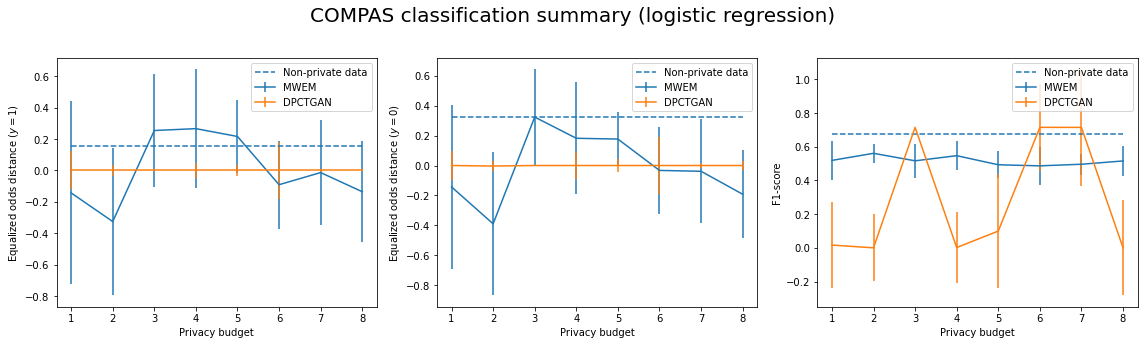

In [24]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")

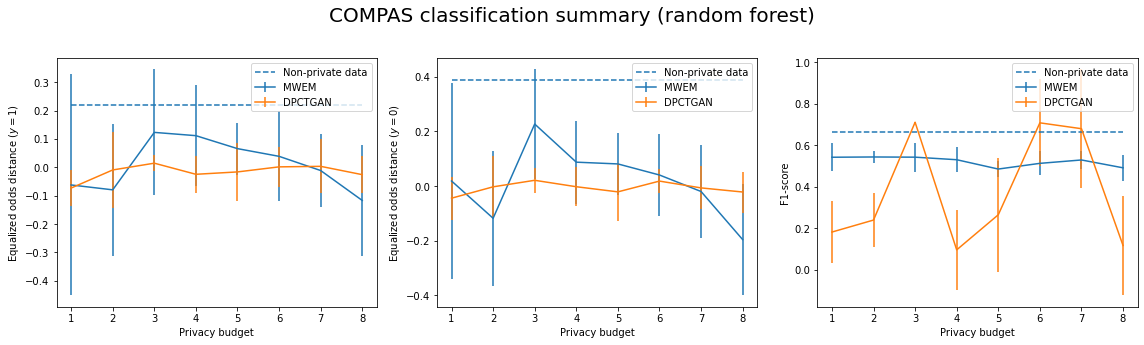

In [25]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")